# $ \text{Raport - Symulacje komputerowe}  $
### $\text{Jakub Ciągło (275986)}$
### $\text{Mateusz Ćwiek (276011)}$
___

### $ \text{Importy} $

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate
from scipy.stats import norm, poisson, kstest, shapiro
from scipy.special import lambertw
import math
import pandas as pd
import timeit
import time

___
# $\text{Zadanie 1 - Generator liczb pseudolosowych ACORN}$

Generator ACORN k-tego rzędu oparty jest na ciągach liczbowych zdefiniowanych poprzez równania rekurencyjne:

$$
X^0_n = X^0_{n-1}, \quad n \geq 1
$$

$$
X^m_n = (X^{m-1}_n + X^m_{n-1}) \mod M, \quad m = 1, \ldots, k, \quad n \geq 1
$$

$$
Y^k_n = \frac{X^k_n}{M}, \quad n \geq 1
$$

Jeśli ziarno (pierwszy element wektora o elementach $X^m_0 \in \{0, \ldots, M\}$, czyli $X^0_0 \in \{1, \ldots, M-1\}$, jest względnie pierwsze z $M$ oraz $M$ jest dostatecznie dużą liczbą naturalną, to generator posiada pożądane cechy a ciąg $Y^k_n$ dla $n \geq 1$ przypomina ciąg IID zmiennych losowych z rozkładu jednostajnego $U(0, 1)$. 




Funkcja `gcd(a, b)` oblicza największy wspólny dzielnik (GCD) dwóch liczb `a` i `b` za pomocą algorytmu Euklidesa. Jest używana do sprawdzenia, czy ziarno (seed) jest względnie pierwsze względem $M$.

In [87]:
def gcd(a, b):
    """
    Oblicza największy wspólny dzielnik (NWD) dwóch liczb a i b.
    """
    while b:
        a, b = b, a % b
    return a

Implementujemy funkcję `ACORN(N, k, M, Lag, seed)`. Zwraca ona $N$ liczb pseudolosowych $Y^k_n$, dla $n = 1, \ldots, N$, korzystając z algorytmu $k$-tego rzędu, przy ominięciu pierwszych $Lag$ wyrazów.


In [88]:
def ACORN(N, k, M, Lag, seed):
    """
    Generuje N liczb pseudolosowych.
    
    Parametry:
    N (int): Liczba generowanych liczb pseudolosowych.
    k (int): Rząd algorytmu.
    M (int): Moduł używany w algorytmie.
    Lag (int): Liczba wyrazów do pominięcia.
    seed (int): Wartość początkowa (ziarno), która musi być względnie pierwsza z M.
    
    Zwraca:
    numpy.ndarray: Tablica zawierająca N wygenerowanych liczb pseudolosowych.
    """
    
    assert gcd(seed, M) == 1, "Seed must be relatively prime to M"

    X = np.zeros((N + Lag, k + 1), dtype=object)     # Inicjalizacja tablicy X
    
    X[0, 0] = seed       # Ustawienie wartości początkowej
    
    for n in range(1, N + Lag):
        X[n, 0] = X[n - 1, 0] 
        for m in range(1, k + 1):
            X[n, m] = (X[n - 1, m - 1] + X[n - 1, m]) % M  
    
    Y = np.array([X[i, k] / M for i in range(Lag, N + Lag)])    # Obliczanie wartości Y po pominięciu Lag wyrazów
    
    return Y

In [89]:
k = 9
M = 2**89 - 1

Tworzymy funkcję `generate_analysis`, która umożliwi porównanie działania generatora liczb pseudolosowych ACORN dla różnych wartości parametrów takich jak `seed`, `N` (liczba generowanych liczb) i `Lag`. 

Funkcja `generate_analysis` wykonuje następujące kroki:
1. Generuje sekwencje liczb pseudolosowych za pomocą ACORN i NumPy dla każdej kombinacji parametrów.
2. Oblicza czas generowania dla obu metod i iloraz tych czasów.
3. Tworzy wykresy ciągu $Y^k_n$, funkcji $Y^k_{n-1} \rightarrow Y^k_n$ oraz histogramy dla obu metod.

Funkcja ta pozwala więc także na łatwe porównanie wyników generowanych przez algorytm ACORN z wynikami generowanymi przez NumPy dla różnych zestawów parametrów.

In [90]:
def generate_analysis(seeds=None, N_values=None, Lags=None, k=9, M=2**89 - 1):
    if seeds is None:
        seeds = [1234567]
    if N_values is None:
        N_values = [1000]
    if Lags is None:
        Lags = [1000]
    
    for seed in seeds:
        for N in N_values:
            for Lag in Lags:
                acorn_time = timeit.timeit(lambda: ACORN(N, k, M, Lag, seed), number=1)
                numpy_time = timeit.timeit(lambda: np.random.random(N), number=1)

                ratio = acorn_time / numpy_time
                
                print(f'Seed: {seed}, N: {N}, Lag: {Lag}')
                print(f'Czas generowania dla ACORN: {acorn_time:.6f} seconds')
                print(f'Czas generowania dla NumPy: {numpy_time:.6f} seconds')
                print(f'Iloraz czasu generowania (ACORN/NumPy): {ratio:.6f}')
                print('-' * 50)

                random_numbers_acorn = ACORN(N, k, M, Lag, seed)
                numpy_random_numbers = np.random.random(N)

                fig, axs = plt.subplots(2, 2, figsize=(10, 5))

                axs[0, 0].plot(random_numbers_acorn, 'o', markersize=1)
                axs[0, 0].set_title('Sekwencja ACORN')
                axs[0, 0].set_xlabel('n')
                axs[0, 0].set_ylabel('Y')

                axs[0, 1].plot(numpy_random_numbers, 'o', color='orange', markersize=1)
                axs[0, 1].set_title('Sekwencja NumPy')
                axs[0, 1].set_xlabel('n')
                axs[0, 1].set_ylabel('Y')

                axs[1, 0].scatter(random_numbers_acorn[:-1], random_numbers_acorn[1:], alpha=0.5, s=1)
                axs[1, 0].set_title('ACORN $Y_{n-1}^k \\rightarrow Y_n^k$')
                axs[1, 0].set_xlabel('$Y_{n-1}^k$')
                axs[1, 0].set_ylabel('$Y_n^k$')

                axs[1, 1].scatter(numpy_random_numbers[:-1], numpy_random_numbers[1:], alpha=0.5, s=1, color='orange')
                axs[1, 1].set_title('NumPy $Y_{n-1} \\rightarrow Y_n$')
                axs[1, 1].set_xlabel('$Y_{n-1}$')
                axs[1, 1].set_ylabel('$Y_n$')

                plt.tight_layout()
                plt.show()

                fig, axs = plt.subplots(1, 2, figsize=(10, 3))

                axs[0].hist(random_numbers_acorn, bins=50, alpha=0.5)
                axs[0].set_title('ACORN Histogram')
                axs[0].set_xlabel('Wartość')
                axs[0].set_ylabel('Częstość występowania')

                axs[1].hist(numpy_random_numbers, bins=50, alpha=0.5, color='orange')
                axs[1].set_title('NumPy Histogram')
                axs[1].set_xlabel('Wartość')
                axs[1].set_ylabel('Częstość występowania')

                plt.tight_layout()
                plt.show()

Na początku wywołamy funkcję dla podstawowych parametrów: `seed=1234567`, `N=1000`, `Lag=1000`.

Seed: 1234567, N: 1000, Lag: 1000
Czas generowania dla ACORN: 0.014847 seconds
Czas generowania dla NumPy: 0.000055 seconds
Iloraz czasu generowania (ACORN/NumPy): 269.954543
--------------------------------------------------


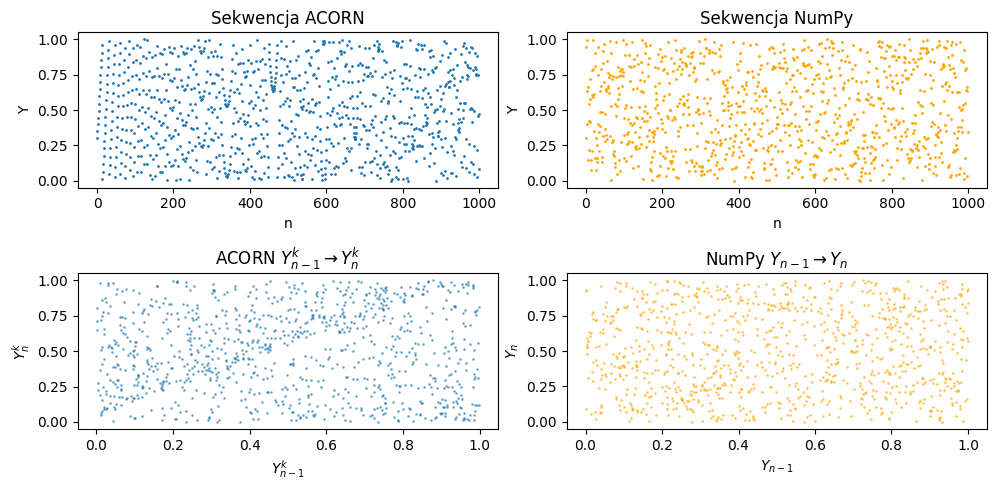

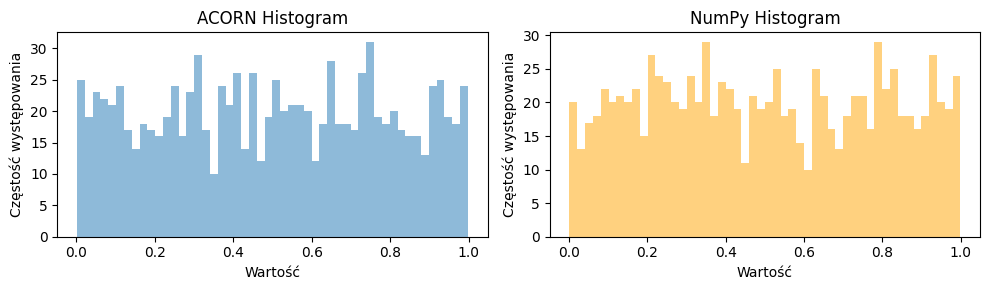

In [78]:
generate_analysis()

W kolejnym kroku zbadamy wpływ różnych wartości `seed` na wyniki: `1`, `10000`, `9999999`, `2**89-2`.

Seed: 1, N: 1000, Lag: 1000
Czas generowania dla ACORN: 0.043736 seconds
Czas generowania dla NumPy: 0.003443 seconds
Iloraz czasu generowania (ACORN/NumPy): 12.703613
--------------------------------------------------


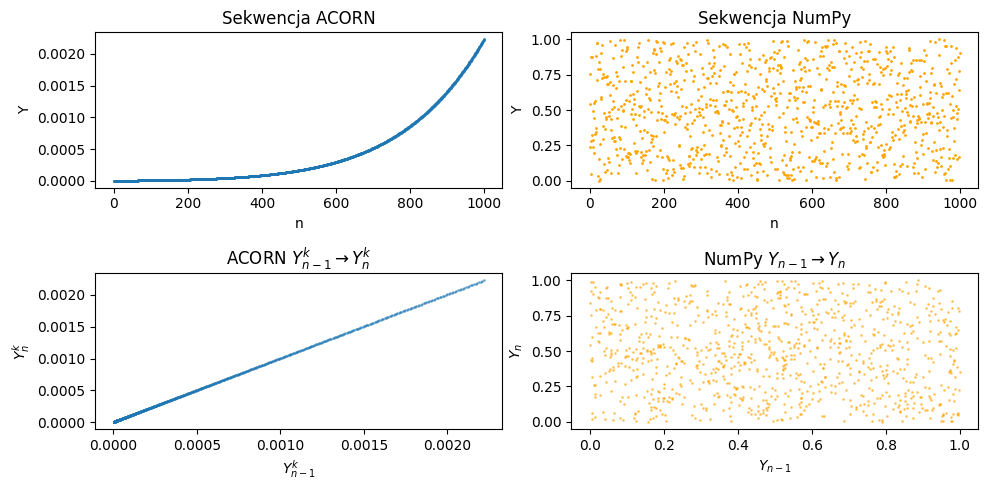

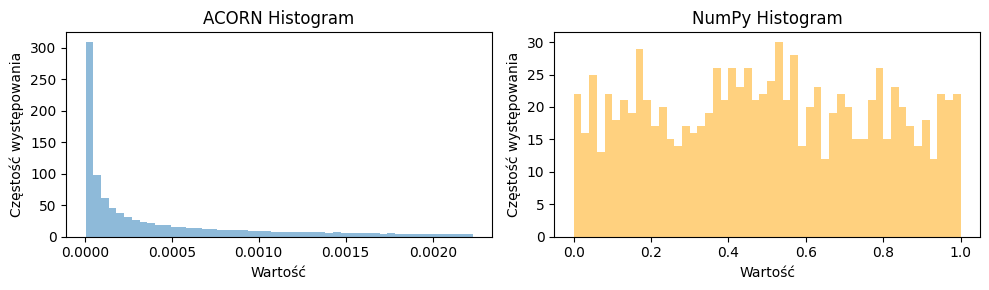

Seed: 10000, N: 1000, Lag: 1000
Czas generowania dla ACORN: 0.013594 seconds
Czas generowania dla NumPy: 0.000024 seconds
Iloraz czasu generowania (ACORN/NumPy): 561.739783
--------------------------------------------------


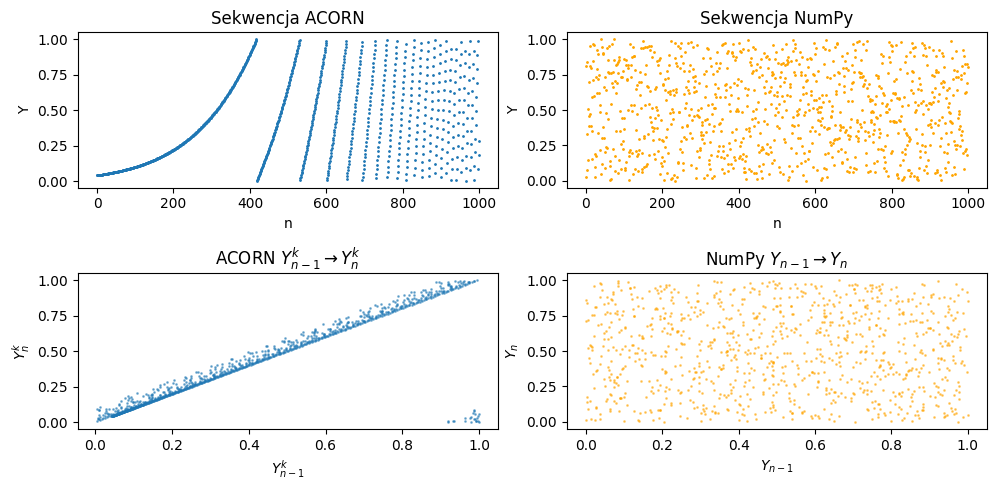

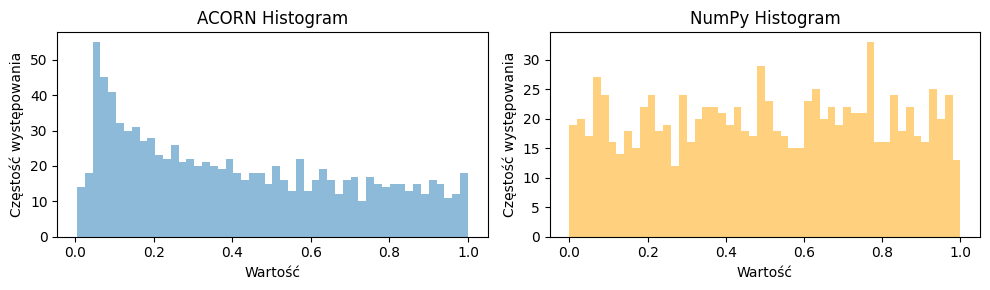

Seed: 9999999, N: 1000, Lag: 1000
Czas generowania dla ACORN: 0.008958 seconds
Czas generowania dla NumPy: 0.000022 seconds
Iloraz czasu generowania (ACORN/NumPy): 412.802022
--------------------------------------------------


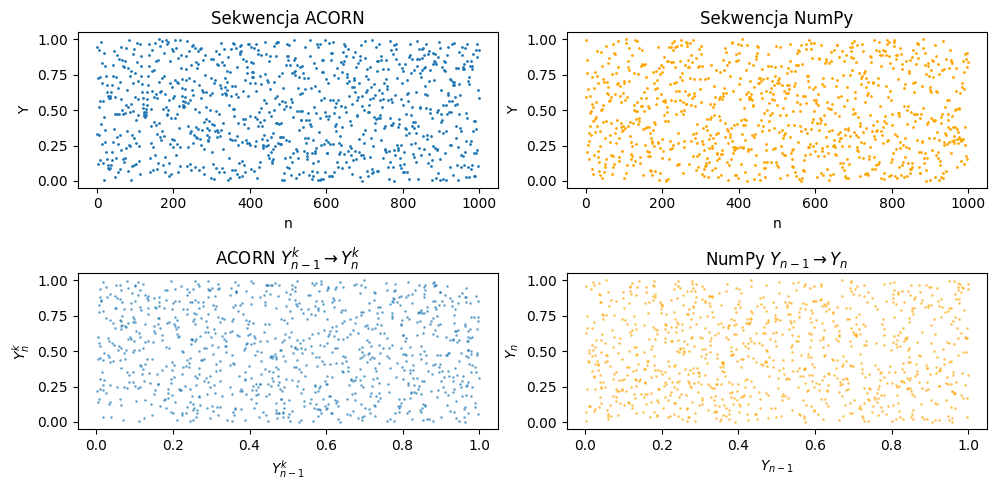

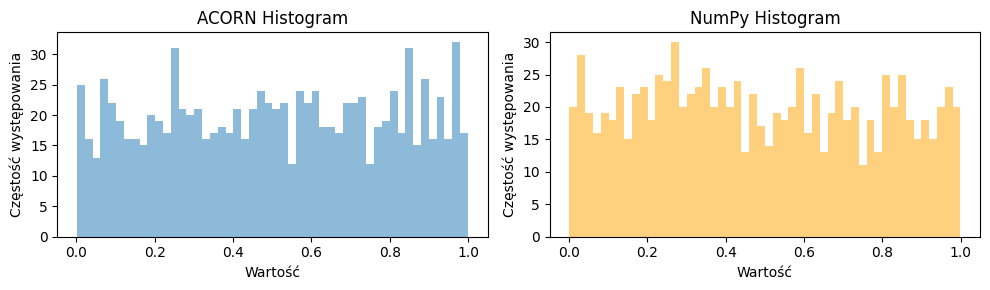

Seed: 618970019642690137449562110, N: 1000, Lag: 1000
Czas generowania dla ACORN: 0.010134 seconds
Czas generowania dla NumPy: 0.000061 seconds
Iloraz czasu generowania (ACORN/NumPy): 165.864158
--------------------------------------------------


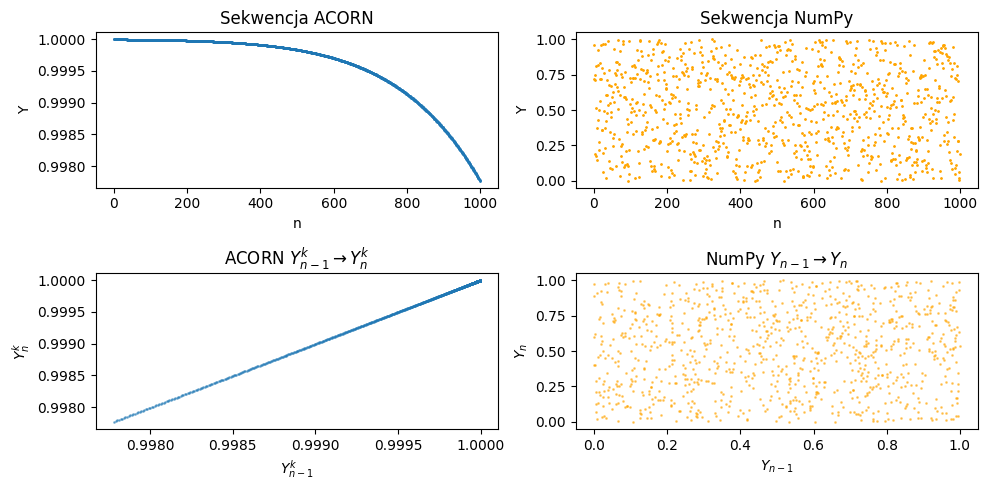

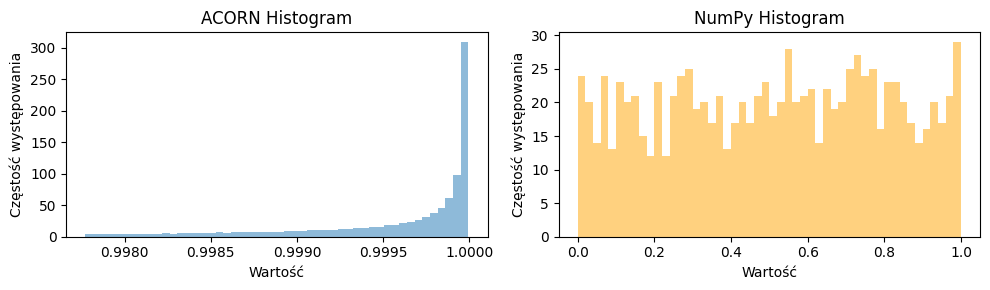

In [91]:
seeds = [1, 10000, 9999999, 2**89-2]
N_values = [1000]
Lags = [1000]

generate_analysis(seeds=seeds, N_values=N_values, Lags=Lags)



Dla małych ziaren (`seed = 1` i `seed = 1000`), sekwencje ACORN są bardzo przewidywalne. Przy `seed = 1`, sekwencja rośnie monotonicznie, a wykres $Y^k_{n-1} \rightarrow Y^k_n$ jest liniowy, co wskazuje na wysoką korelację między kolejnymi wartościami i brak losowości. Histogram pokazuje bardzo nierównomierny rozkład wartości.

Dla `seed = 1000`, sekwencja zaczyna oscylować, a wykres $Y^k_{n-1} \rightarrow Y^k_n$ pokazuje pewne rozproszenie, ale nadal widoczne są regularności. Histogram staje się bardziej równomierny, ale nadal pokazuje pewne nierówności.

Dla większego ziarna (`seed = 9999999`), sekwencja ACORN jest już chaotyczna i przypomina tę generowaną przez NumPy. Wykres $Y^k_{n-1} \rightarrow Y^k_n$ jest rozproszony, co sugeruje brak korelacji między kolejnymi wartościami, co także sugeruje lepszą losowość. Histogramy stają się bardziej równomierne, podobnie jak w przypadku NumPy, co świadczy o poprawie jakości generatora ACORN przy większych ziarnach.

Dla seeda o wartości bliskiej maksymalnej wartości modułu, takiego jak `2**89 - 2`, sekwencje ACORN wykazują bardzo przewidywalne wzory. Sekwencja opada monotonicznie, a wykres $Y^k_{n-1} \rightarrow Y^k_n$ jest prawie liniowy, co wskazuje na wysoką korelację między kolejnymi wartościami i brak losowości. Histogram pokazuje skumulowanie wartości w pobliżu maksimum. Może to wynikać z bliskości wartości seeda do modułu `M = 2**89 - 1`, co powoduje problemy z dystrybucją losowych wartości i wpływa negatywnie na jakość losowości.


To sugeruje, że ziarno `seed = 9999999` jest najbardziej odpowiednie do dalszej analizy. Teraz przeanalizujemy działanie dla mniejszej wartości `N = 100`.

Seed: 9999999, N: 100, Lag: 1000
Czas generowania dla ACORN: 0.005818 seconds
Czas generowania dla NumPy: 0.000023 seconds
Iloraz czasu generowania (ACORN/NumPy): 257.433616
--------------------------------------------------


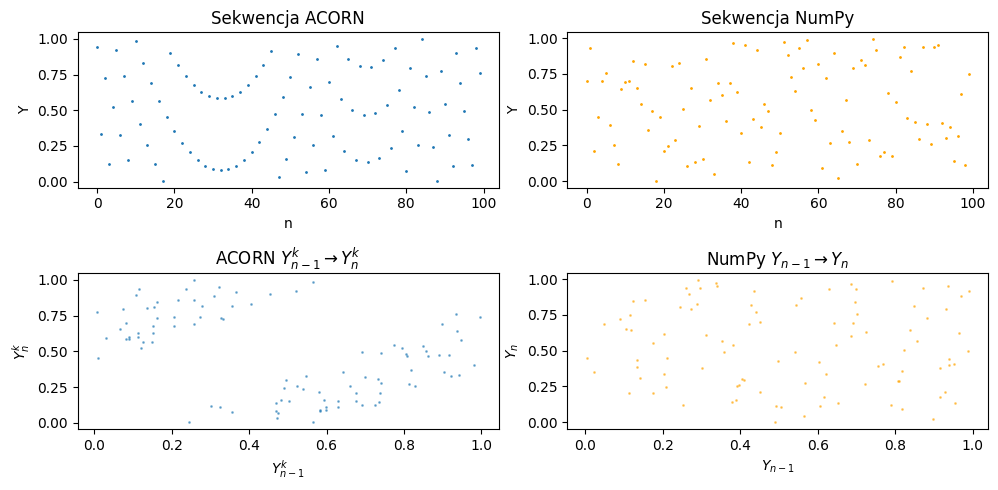

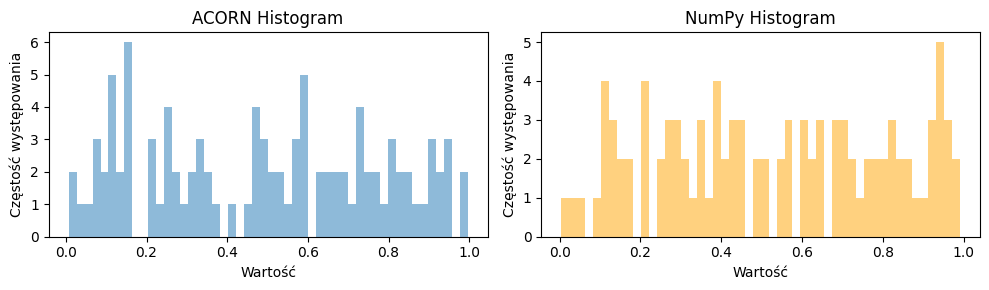

In [80]:
seeds = [9999999]
N_values = [100]
Lags = [1000]

generate_analysis(seeds=seeds, N_values=N_values, Lags=Lags)

Dla `N = 100`, sekwencja ACORN w okolicach `n` od 20 do 40 wykazuje dość dziwne zachowanie. Wykres $Y^k_{n-1} \rightarrow Y^k_n$ pokazuje, że kropki nie są równomiernie rozłożone, co wskazuje na pewne nierówności w losowości. Jednak histogram wskazuje na podobny rozkład wartości jak NumPy. Zatem przy mniejszych wartościach `N` mogą pojawiać się pewne nierówności w losowości.


W kolejnym kroku zbadamy działanie generatora dla różnych wartości `Lag: 100, 100000`.

Seed: 9999999, N: 1000, Lag: 100
Czas generowania dla ACORN: 0.006543 seconds
Czas generowania dla NumPy: 0.000288 seconds
Iloraz czasu generowania (ACORN/NumPy): 22.712253
--------------------------------------------------


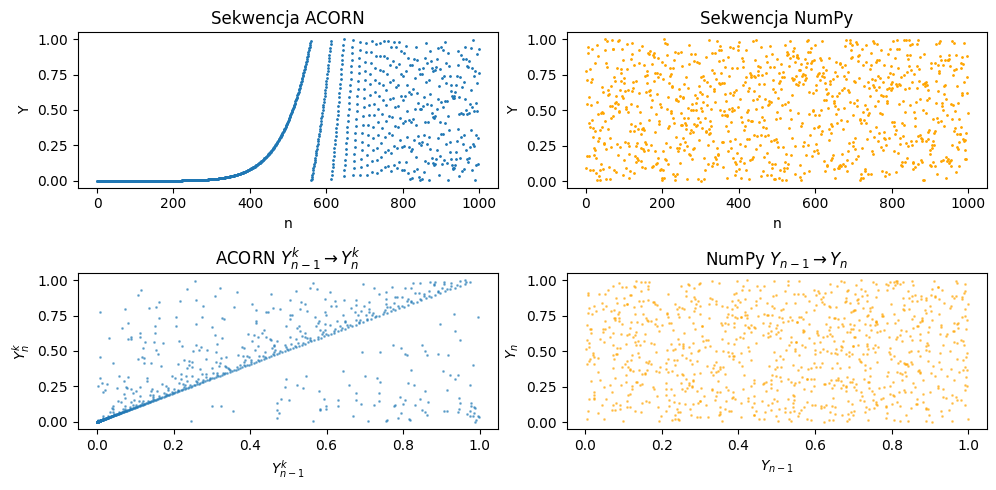

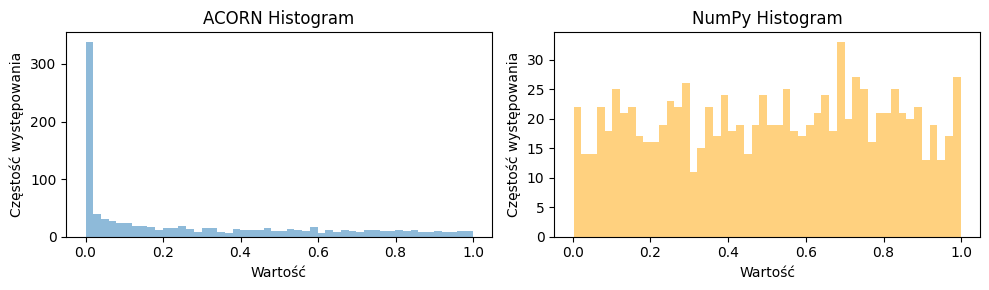

Seed: 9999999, N: 1000, Lag: 100000
Czas generowania dla ACORN: 0.393625 seconds
Czas generowania dla NumPy: 0.000023 seconds
Iloraz czasu generowania (ACORN/NumPy): 17417.047823
--------------------------------------------------


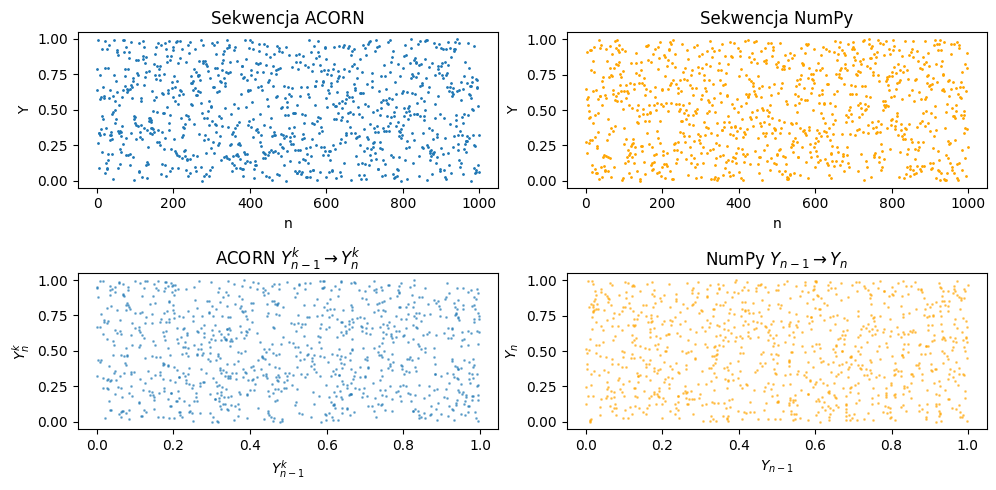

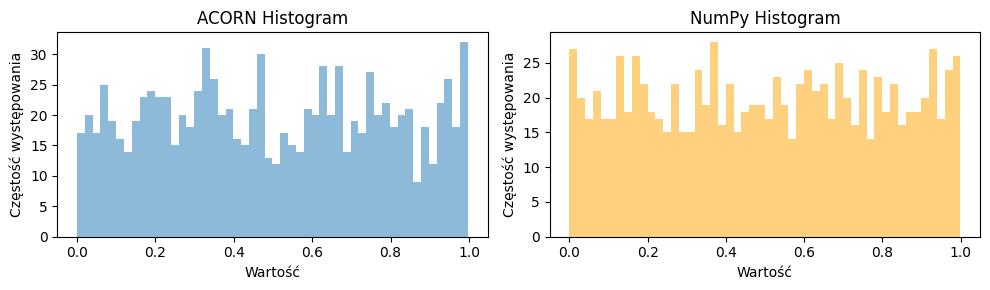

In [81]:
seeds = [9999999]
N_values = [1000]
Lags = [100, 100000]

generate_analysis(seeds=seeds, N_values=N_values, Lags=Lags)

Dla `Lag = 100`, sekwencja ACORN rośnie monotonicznie do połowy ciągu, wykazuje wyraźne oscylacje dopiero w drugiej połowie ciągu. Wykres $Y^k_{n-1} \rightarrow Y^k_n$ pokazuje pewne regularności, co sugeruje ograniczoną losowość. Histogram wskazuje na nierównomierny rozkład wartości, z dużą koncentracją w niskich wartościach, co także świadczy o słabszej jakości losowości.

Dla `Lag = 10000`, sekwencja ACORN jest bardziej rozproszona i równomierna, podobnie jak przy dotychczas używanym w analizie `Lag = 1000`. Wykres $Y^k_{n-1} \rightarrow Y^k_n$ oraz histogram pokazują równomierne rozproszenie, co wskazuje na poprawę losowości.

Podsumowując, wraz ze wzrostem wartości `Lag`, generator ACORN wykazuje lepsze właściwości losowe, wyniki są równomierne i zbliżone do tych generowanych przez NumPy. Istotność `Lag` polega na pominięciu początkowych wartości w sekwencji, które mogą być silnie skorelowane i mniej losowe. Pomijając większą liczbę początkowych wartości, generator ACORN ma większą szansę na osiągnięcie stanu stabilnego, w którym generowane liczby mają lepsze właściwości losowe. 


Finalnie przedstawimy analizę czasów generowania liczb pseudolosowych przez generator ACORN w porównaniu do NumPy dla 200 różnych wartości `N` w zakresie od 100 do 100000. Ze względu na bardzo krótkie czasy generowania przez NumPy, wyniki zostaną przedstawione jako iloraz czasu generowania ACORN do czasu generowania NumPy, co ułatwi porównanie wydajności obu metod. Implementujemy więc funkcję `compare_generation_times`.

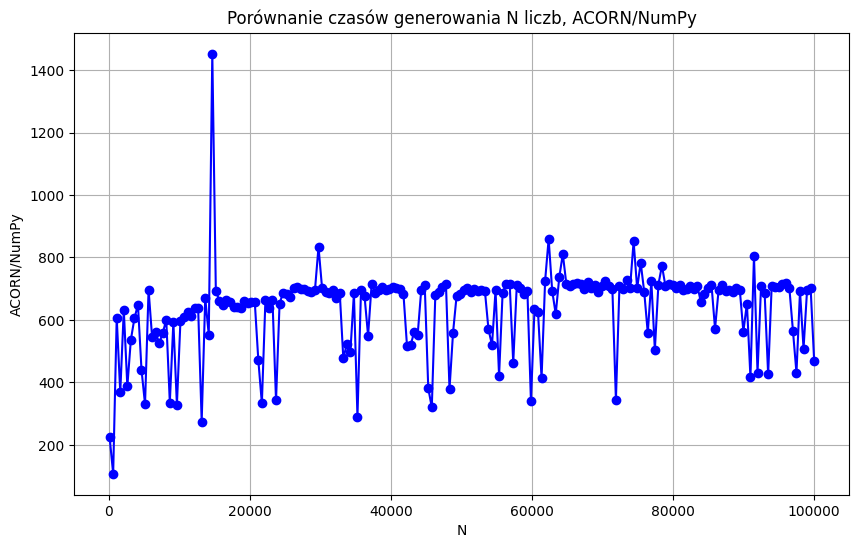

In [82]:
def compare_generation_times(N_values, k, M, Lag, seed):
    num_tests = len(N_values)
    acorn_times = np.zeros(num_tests)
    numpy_times = np.zeros(num_tests)
    ratios = np.zeros(num_tests)

    for i, N in enumerate(N_values):
        acorn_time = timeit.timeit(lambda: ACORN(N, k, M, Lag, seed), number=1)
        acorn_times[i] = acorn_time
        
        numpy_time = timeit.timeit(lambda: np.random.random(N), number=1)
        numpy_times[i] = numpy_time

        ratios[i] = acorn_time / numpy_time  

    plt.figure(figsize=(10, 6))
    plt.plot(N_values, ratios, marker='o', linestyle='-', color='b')
    plt.xlabel('N')
    plt.ylabel('ACORN/NumPy')
    plt.title('Porównanie czasów generowania N liczb, ACORN/NumPy')
    plt.grid(True)
    plt.show()

N_values = np.linspace(100, 100000, num=200, dtype=int)  
Lag = 1000
seed = 1234567

compare_generation_times(N_values, k, M, Lag, seed)

Wykres ilorazu czasów generowania liczb pseudolosowych przez ACORN i NumPy pokazuje, że ACORN jest znacząco wolniejszy od NumPy, przy czym iloraz czasów waha się w zakresie od około 200 do 800 dla większości wartości `N`. Pomimo tego, generator ACORN zachowuje stabilną wydajność przy rosnących wartościach `N`, co oznacza, że jego czas generowania rośnie liniowo wraz z rozmiarem danych, ale nadal pozostaje znacznie wolniejszy od NumPy. 

### Ogólne wnioski 

1. **Jakość losowości:** Generator ACORN działa dobrze przy odpowiednio dobranym dużym ziarnie (`seed`) i wartości pominięcia początkowych wyrazów (`Lag`), co pozwala na uzyskanie równomiernych i chaotycznych sekwencji, charakteryzujących się dobrą losowością.
2. **Porównanie z NumPy:** Przy optymalnych parametrach, wyniki generowane przez ACORN są porównywalne z wynikami generowanymi przez wbudowany generator NumPy, co wskazuje na jego skuteczność.
3. **Czas generowania:** Choć ACORN potrafi generować liczby o wysokiej jakości losowości, jest znacząco wolniejszy od NumPy. 

Wysoka jakość losowości osiągana przez generator ACORN wynika z jego algorytmicznej struktury, która przy odpowiednim ziarnie i odpowiednim `Lag` zapewnia równomierne rozproszenie wartości i chaotyczne sekwencje, nie wykazujące regularności. Dzięki temu ACORN może być solidnym narzędziem do generowania liczb pseudolosowych, choć jego użycie wiąże się z większym nakładem czasowym w porównaniu do NumPy.

___
# $\text{Zadanie 2 - Generowanie rozkładu normalnego}$
W tym zadaniu zaimplementowano różne metody generowania próbek z rozkładu normalnego. Były to metody poznane na zajęciach, podane w poleceniu oraz samodzielnie zaimplementowane. 

 Na początek stworzono funkcję, która pomoże w generowaniu wykresów gęstości i dystrybuant empirycznych, a także w porównaniu ich z teoretycznymi odpowiednikami. 

In [3]:
def plot_pdf_cdf(data, mu=0, sigma=1):
    
    x_theor = np.linspace(min(data), max(data), n)
    y_theor_pdf = norm.pdf(x_theor, mu, sigma)
    y_theor_cdf = norm.cdf(x_theor, mu, sigma)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_theor, y_theor_cdf, label="dystrybuanta teoretyczna", color = 'red')
    sns.ecdfplot(data, label="dystrybuanta empiryczna",linestyle = '--')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x_theor, y_theor_pdf, color="r", label="gęstość teoretyczna")
    sns.histplot(data, kde=True, stat="density", label="gęstość empiryczna")
    plt.legend()
    plt.suptitle(f"Rozkład normalny N({mu}, {sigma})", fontsize=16)
    plt.show()


Następnie wyznaczono wartości $\mu$ oraz $\sigma$, tak aby generowane rozkłady były rozkładami standardowymi. Wyznaczono również wielkość próbki $n$.

In [19]:
mu = 0
sigma = 1
n = 1000

## Pierwszy krok - dotychczasowe oraz samodzielne implementacje 
Pierwszym krokiem było zaimplementowanie generatorów metodami poznanymi na wykładach, laboratoriach oraz samodzielnie wybranych metod poznanych w internecie.

#### 1. Metoda odwrotnej dystrybuanty
Pierwszą poznaną metodą jest metoda odwrotnej dystrybuanty. Poniżej napisano funkcję, która stworzy próbkę rozkładu normalnego.

Funkcja `normal(mu, sigma, n)` generuje `n` liczb losowych z rozkładu normalnego o średniej $\mu$ i odchyleniu standardowym $\sigma$. Funkcja działa na zasadzie przekształcania losowych wartości z rozkładu jednostajnego na wartości z rozkładu normalnego. Najpierw generowane są `n` losowe liczby $ U $ z rozkładu jednostajnego $[0, 1]$ za pomocą `np.random.rand(n)`. Następnie, wartości te są przekształcane na rozkład normalny przy użyciu funkcji `norm.ppf(U)`, co daje wartości $Z= \Phi^{-1}(U) $ .
Na koniec, wartości $ Z $ są skalowane przez odchylenie standardowe $\sigma$ i przesunięte o średnią $\mu$, co daje liczby z rozkładu normalnego $N(\mu, \sigma^2)$.

Poniżej znajduje się implementacja wspomnianej metody. 


In [20]:
def normal(mu, sigma, n):
    U = np.random.rand(n)
    Z = norm.ppf(U)
    return mu + sigma * Z

Następnie zmierzono czas generowania próbki oraz stworzono wykres dystybuanty i gęstości.

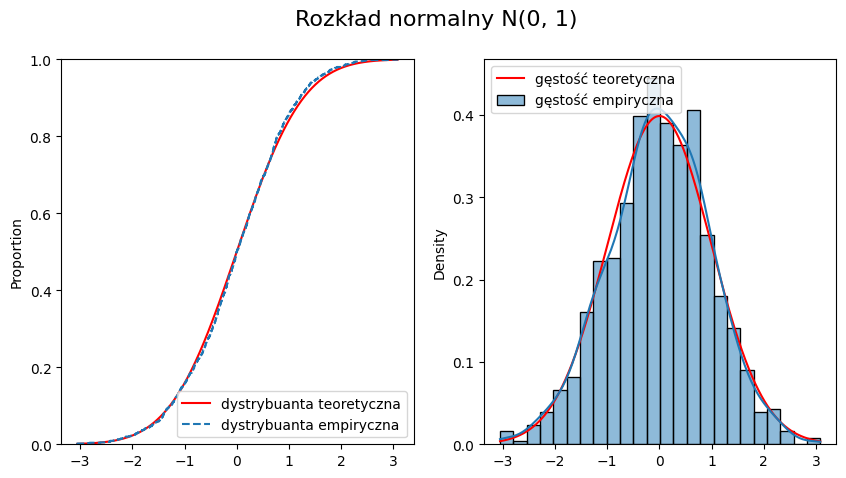

Czas wygenerowania 1000 wartości dla metody odwrtonej dystrybuanty to: 0.0003293999470770359 s


In [21]:
generated_normal = normal(mu, sigma, n)
time1 = timeit.timeit(lambda: normal(mu,sigma,n), number = 1)
plot_pdf_cdf(generated_normal)
print('Czas wygenerowania {} wartości dla metody odwrtonej dystrybuanty to:'.format(n),time1,'s' )

#### 2. Metoda Boxa-Mullera.
Funkcja `BoxMuller(n)` generuje `n` liczb losowych z rozkładu normalnego za pomocą metody Boxa-Mullera. Algorytm ten wykorzystuje dwie niezależne zmienne losowe o rozkładzie jednostajnym, które są przekształcane w dwie niezależne zmienne losowe z rozkładu normalnego.

Najpierw generowane są dwie niezależne zmienne losowe $ U_1 $ i $ U_2 $ z rozkładu jednostajnego $[0, 1]$ za pomocą funkcji `np.random.uniform(0, 1, n)`. Następnie stosuje się przekształcenie Boxa-Mullera, gdzie wartości te są przekształcane na zmienne losowe z rozkładu normalnego:

$$
\text{factor} = \sqrt{-2 \ln(U_1)}
$$

$$
X = \sqrt{-2 \ln(U_1)} \cdot \cos(2 \pi U_2)
$$

$$
Y = \sqrt{-2 \ln(U_1)} \cdot \sin(2 \pi U_2)
$$

Wartości $ X $ i $ Y $ są dwiema niezależnymi zmiennymi losowymi o rozkładzie normalnym.

Poniżej znajduje się implementacja tej metody.



In [22]:
def BoxMuller(n):
    U1 = np.random.uniform(0, 1, n)
    U2 = np.random.uniform(0, 1, n)
    factor = np.sqrt(-2 * np.log(U1))
    X = np.sqrt(-2 * np.log(U1)) * np.cos(2 * np.pi * U2)
    Y = np.sqrt(-2 * np.log(U1)) * np.sin(2 * np.pi * U2)
    return X, Y

Następnie wygenerowano próbkę wspomnianą metodą, zmierzono czas jej generowania oraz narysowano wykresy dystybuanty oraz gęstości.

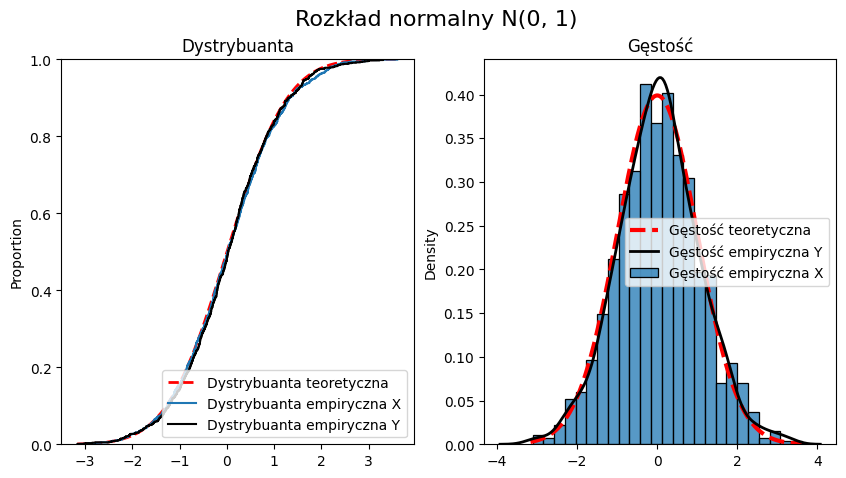

Czas wygenerowania 1000 wartości dla metody Boxa-Mullera to: 0.00023779971525073051 s


In [23]:
x1, y1 = BoxMuller(n)
time_box_muller = timeit.timeit(lambda: BoxMuller(n), number = 1)


x_theor = np.linspace(min(np.concatenate([x1, y1])), max(np.concatenate([x1, y1])), n)
y_theor_cdf = norm.cdf(x_theor, 0, 1)
y_theor_pdf = norm.pdf(x_theor, 0, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(
    x_theor, y_theor_cdf, linestyle="dashed", color="r", linewidth=2, label="Dystrybuanta teoretyczna"
)
sns.ecdfplot(x1, label="Dystrybuanta empiryczna X")
sns.ecdfplot(y1, color="k", label="Dystrybuanta empiryczna Y")
plt.title("Dystrybuanta")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(
    x_theor, y_theor_pdf, linestyle="dashed", color="r", linewidth=3, label="Gęstość teoretyczna"
)
sns.histplot(x1, stat="density", label="Gęstość empiryczna X")
sns.kdeplot(y1, label="Gęstość empiryczna Y", color="k", linewidth=2)
plt.title("Gęstość")
plt.legend()

plt.suptitle(f"Rozkład normalny N({mu}, {sigma})", fontsize=16)
plt.show()
print('Czas wygenerowania {} wartości dla metody Boxa-Mullera to:'.format(n),time_box_muller,'s' )

#### 3. Metoda biegunowa Boxa-Mullera.

Poniższa funkcja `polar_BoxMuller(n)` generuje liczby losowe z rozkładu normalnego za pomocą metody biegunowej Boxa-Mullera. W przeciwieństwie do standardowej metody Boxa-Mullera, ta metoda wykorzystuje zmienne losowe o rozkładzie jednostajnym w zakresie $[-1, 1]$.

Algorytm polega na generowaniu par zmiennych losowych $ (V_1, V_2) $ o rozkładzie jednostajnym w przedziale $[-1, 1]$, które są interpretowane jako współrzędne punktu w przestrzeni dwuwymiarowej. Następnie obliczany jest kwadrat odległości od początku układu współrzędnych, $ R^2 = V_1^2 + V_2^2 $, aby sprawdzić, czy punkt leży wewnątrz koła o promieniu 1.

Następnie, jeśli wartość $ R^2 $ mieści się w przedziale $(0, 1]$, obliczany jest współczynnik skalowania na podstawie wzoru: $\text{factor} = \sqrt{-2 \frac{\ln(R^2)}{R^2}}$

Wartości $ V_1 $ i $ V_2 $ są przemnożane przez ten współczynnik, dając dwie niezależne zmienne losowe $ X $ i $ Y $ o rozkładzie normalnym.


In [24]:
def polar_BoxMuller(n):
    samples_x = []
    samples_y = []
    while len(samples_x) < n:
        V1 = np.random.uniform(-1, 1)
        V2 = np.random.uniform(-1, 1)
        R2 = V1**2 + V2**2
        if R2 <= 1 and R2 > 0:
            factor = np.sqrt(-2 * np.log(R2) / R2)
            samples_x.append(V1 * factor)
            samples_y.append(V2 * factor)
    return np.array(samples_x), np.array(samples_y)

Wygenerowano próbkę i tak jak w poprzednich przypadkach zmierzono czas generowania i stworzono odpowiednie wykresy. 

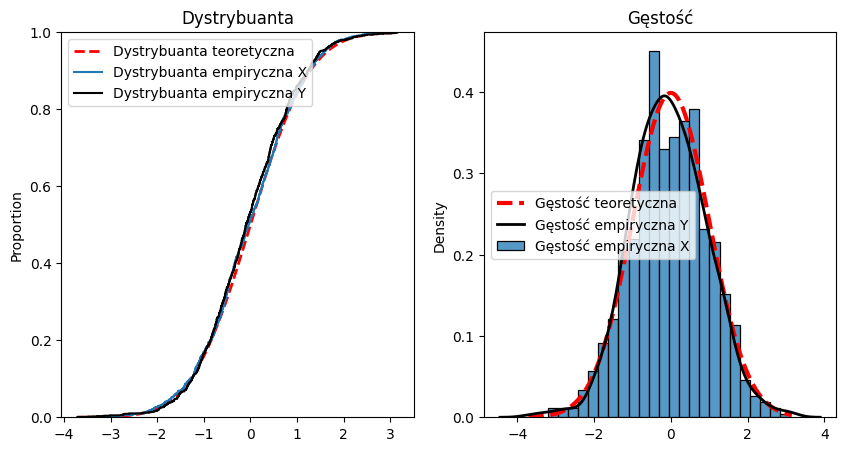

Czas wygenerowania 1000 wartości dla metody biegunowej Boxa-Mullera to: 0.025010999757796526 s


In [25]:
x2, y2 = polar_BoxMuller(n)
time_polar_box_muller = timeit.timeit(lambda: polar_BoxMuller(n), number = 1)


x_theor = np.linspace(min(np.concatenate([x2, y2])), max(np.concatenate([x2, y2])), n)
y_theor_cdf = norm.cdf(x_theor, 0, 1)
y_theor_pdf = norm.pdf(x_theor, 0, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(
    x_theor, y_theor_cdf, linestyle="dashed", color="r", linewidth=2, label="Dystrybuanta teoretyczna"
)
sns.ecdfplot(x2, label="Dystrybuanta empiryczna X")
sns.ecdfplot(y2, color="k", label="Dystrybuanta empiryczna Y")
plt.title("Dystrybuanta")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(
    x_theor, y_theor_pdf, linestyle="dashed", color="r", linewidth=3, label="Gęstość teoretyczna"
)
sns.histplot(x2, stat="density", label="Gęstość empiryczna X")
sns.kdeplot(y2, label="Gęstość empiryczna Y", color="k", linewidth=2)
plt.title("Gęstość")
plt.legend()
plt.show()

print('Czas wygenerowania {} wartości dla metody biegunowej Boxa-Mullera to:'.format(n),time_polar_box_muller,'s' )

#### 4. Przyspieszony algorytm biegunowej metody, korzystając ze źródła https://quantgirl.blog/comparing-box-muller-and-marsaglia-bray/.
Ostatnią w tym kroku metodą jest przyspieszona metoda biegunowa Boxa - Mullera. Metoda ta wykorzystuje zaawansowane obliczenia, aby przyspieszyć proces generowania próbek.

Obliczana jest pomocnicza wartość `p` oraz zmienna `aux`. Następnie, na podstawie wartości `p` oraz liczby $n$, obliczany jest przybliżony rozmiar próbki $N$. Generowane są dwie zmienne losowe $w1$ i $w2$ z rozkładu jednostajnego na przedziale $[-1, 1]$ o długości $N$. Liczone są wartości $s$ jako suma kwadratów $w1$ i $w2$. Wybierane są te wartości, które spełniają warunek $s < 1$. Na podstawie wybranych wartości liczone są zmienne losowe $z1$ i $z2$ z rozkładu normalnego.

Poniżej znajduję się zaimplementowana metoda.


In [26]:
p = np.pi / 4
aux = p * (1 - p)


def fast_polar_BoxMuller(n):
    x = (3 * math.sqrt(aux) + math.sqrt(9 * aux + p * n)) / p
    N = math.ceil(x * x)

    w1 = np.random.rand(N) * 2 - 1
    w2 = np.random.rand(N) * 2 - 1
    s = w1 * w1 + w2 * w2

    index = s < 1

    w1 = w1[index][:n]
    w2 = w2[index][:n]
    s = s[index][:n]

    t = np.sqrt(-2 * np.log(s) / s)
    z1 = w1 * t
    z2 = w2 * t

    return z1, z2

Wygenerowano próbkę, zmierzono czas, który zajęło jej generowanie oraz stworzono wykresy gęstości i dystrybuanty.

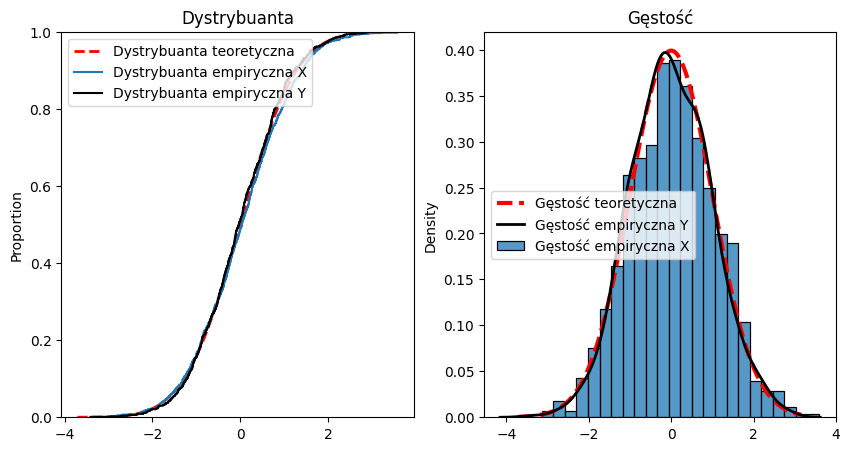

Czas wygenerowania 1000 wartości dla przyspieszonej metody biegunowej Boxa-Mullera to: 0.02182300016283989 s


In [27]:
x3, y3 = fast_polar_BoxMuller(n)
time_fast_box_muller = timeit.timeit(lambda: polar_BoxMuller(n), number = 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(
    x_theor, y_theor_cdf, linestyle="dashed", color="r", linewidth=2, label="Dystrybuanta teoretyczna"
)
sns.ecdfplot(x3, label="Dystrybuanta empiryczna X")
sns.ecdfplot(y3, color="k", label="Dystrybuanta empiryczna Y")
plt.title("Dystrybuanta")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(
    x_theor, y_theor_pdf, linestyle="dashed", color="r", linewidth=3, label="Gęstość teoretyczna"
)
sns.histplot(x3, stat="density", label="Gęstość empiryczna X")
sns.kdeplot(y3, label="Gęstość empiryczna Y", color="k", linewidth=2)
plt.title("Gęstość")
plt.legend()
plt.show()

print('Czas wygenerowania {} wartości dla przyspieszonej metody biegunowej Boxa-Mullera to:'.format(n),time_fast_box_muller,'s' )

## Drugi krok - dodatkowe metody generowania rozkładu normalnego.
W drugim kroku zaimplementowano trzy dodatkowe metody generowania rozkładu normalnego.

#### 1. Metoda tuzina.
Jako pierwszą zaimplementowano funkcję, ktora generuję rozklad normalny metodą tuzina.
Metoda tuzina generuje liczby losowe o rozkładzie normalnym poprzez sumowanie 12 zmiennych losowych o rozkładzie jednostajnym z przedziału [0,1] i przesunięcie wyniku o 6. Następnie wynik jest skalowany przez odchylenie standardowe $\sigma$ i przesunięty o średnią $\mu$ co daje liczby z rozkładu normalnego $N(\mu , \sigma) $. Poniżej znajduje się implementacja funkcji 

In [28]:
def tuzin(mu, sigma):
    U = np.random.uniform(0, 1, 12)
    S = np.sum(U)
    X = S - 6
    return sigma * X + mu

Następnie za pomocą powyższej funkcji wygenerowano próbkę z rozkładu normalnego, zmierzono czas generowania oraz narysowano wykres dystrybuanty i gęstości.

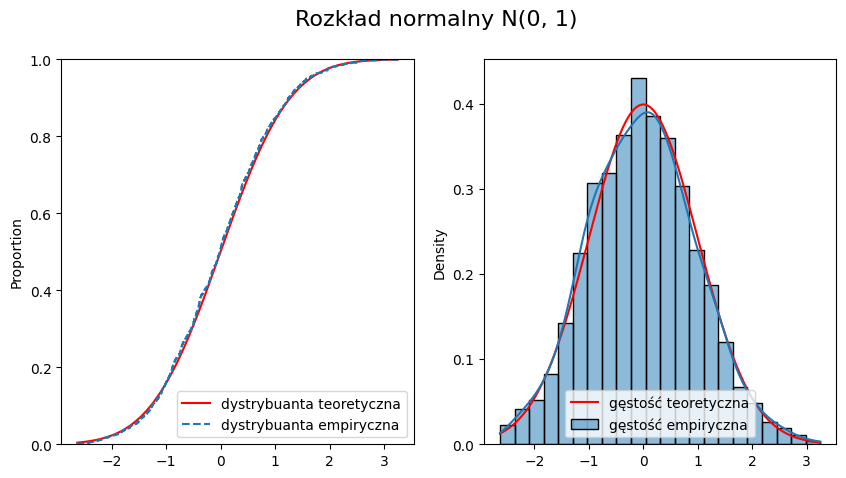

Czas wygenerowania 1000 wartości dla metody tuzina to: 0.029400000348687172 s


In [29]:
def generator_tuzin(n):
    generated_tuzin = np.zeros(n)
    for i in range(n):
        generated_tuzin[i] = tuzin(mu, sigma)
    return generated_tuzin
time_tuzin = timeit.timeit(lambda: generator_tuzin(n), number = 1)
tuzin_sample = generator_tuzin(n)
plot_pdf_cdf(tuzin_sample)
print('Czas wygenerowania {} wartości dla metody tuzina to:'.format(n),time_tuzin,'s' )

#### 2. Metoda zigguratu.
Jako drugą zaimplementowano funkcję, która stworzy próbkę z rozkładu normnalnego za pomocą metody zigguratu.

Ta metoda jest oparta na idei "ziggurat", czyli struktury piramidy schodowej, której stopnie reprezentują punkty z rozkładu normalnego.
W metodzie Ziggurata inicjalizowana jest struktura Ziggurata, która składa się z określonej liczby warstw `m`. Dla każdej warstwy tworzona jest tabela `layers`, która przechowuje parametry dla danej warstwy. Początkowe wartości dla pierwszej warstwy obliczane są na podstawie ustalonych wzorów.
Następnie, wypełniane są kolejne warstwy Ziggurata. Wartości dla tych warstw obliczane są na podstawie parametrów poprzednich warstw, zapewniając rosnące wartości gęstości prawdopodobieństwa.
W trzecim etapie następuje generacja próbek z rozkładu normalnego. Losowane są wartości na podstawie wygenerowanych wcześniej warstw. Wykorzystywane są losowe liczby do wyboru odpowiedniej warstwy oraz do generacji samych wartości, tak aby uzyskać próbki zgodne z rozkładem normalnym.

Poniżej znajduje się implementacja tej metody, wraz z czasem wygenerowania próbek dla danej liczby `n`:


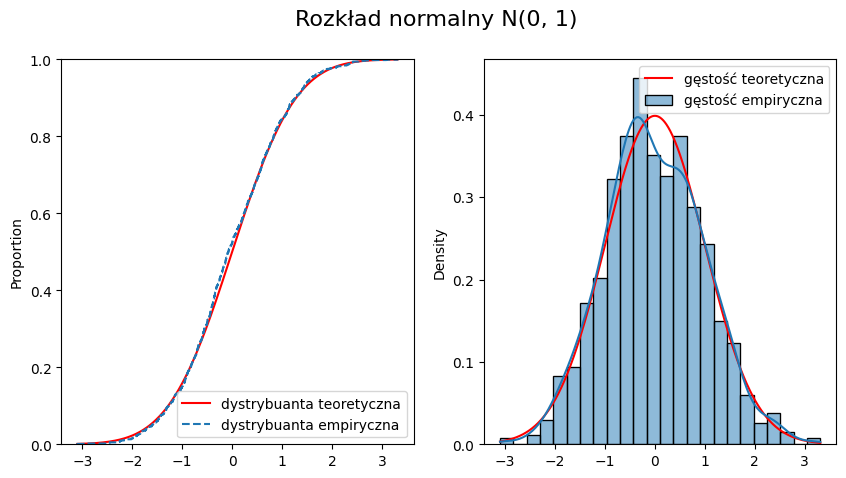

Czas wygenerowania 1000 wartości dla metody zigguratu to: 0.01898169983178377 s


In [30]:
def ziggurat(n):
    m = 256
    layers = np.zeros((m, 2))
    
    x1 = 3.6541528853610088
    y1 = np.exp(-x1**2 / 2)
    layers[0, 0] = x1
    layers[0, 1] = y1
    
    tail_area = norm.sf(x1)
    
    A = x1 * y1 + tail_area
    
    for i in range(1, m):
        layers[i, 1] = layers[i-1, 1] + A / layers[i-1, 0]
        layers[i, 0] = np.sqrt(-2 * np.log(layers[i, 1]))
    
    Xs = np.zeros(n)
    
    for i in range(n):
        while True:
            index = int(np.floor(m * np.random.uniform()))
            if index == m:
                index = m - 1  
            U0 = 2 * np.random.uniform() - 1
            if index == 0:
                x = U0 * A / layers[0, 1]
            else:
                x = U0 * layers[index, 0]
            if np.abs(x) < layers[index, 0]:
                Xs[i] = x
                break
            if index == 0:
                while True:
                    x = -np.log(np.random.uniform()) / layers[0, 0]
                    y = -np.log(np.random.uniform())
                    if 2 * y > x**2:
                        Xs[i] = x + layers[0, 0]
                        break
                break
            else:
                y = layers[index, 1] * np.random.uniform() * (layers[index + 1, 1] - layers[index, 1])
                if y < np.exp(-x**2 / 2):
                    Xs[i] = x
                    break
    
    return Xs * sigma + mu

time_zigg = timeit.timeit(lambda: ziggurat(n), number = 1)
generated_ziggurat = ziggurat(n)
plot_pdf_cdf(generated_ziggurat)
print('Czas wygenerowania {} wartości dla metody zigguratu to:'.format(n),time_zigg,'s' )

#### 3. Generator wbudowany w pakiet Numpy
Jako ostatni zostanie sprawdzony generator wbudowany w pakiet Numpy, aby porównać jego funkcjonowanie z metodami zaimplementowanymi wcześniej. Dla niego również zostanie zmierzony czas oraz narysowane zostaną odpowiednie wykresy.

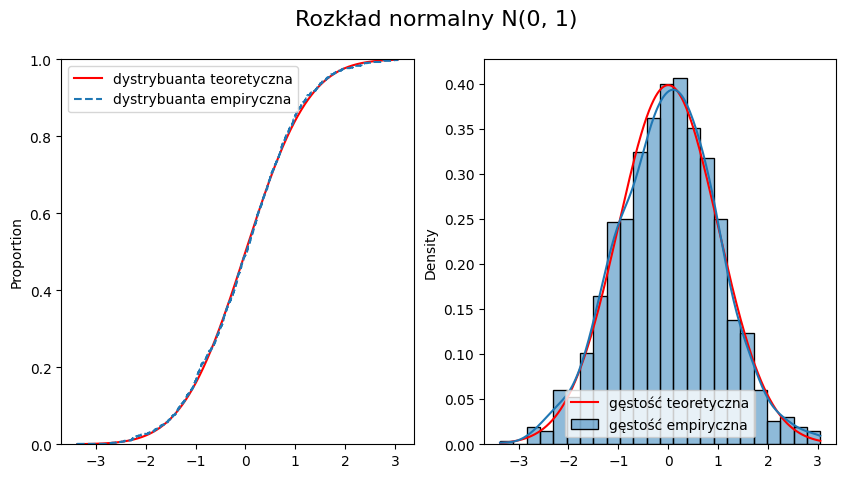

Czas wygenerowania 1000 wartości dla generatora numpy to: 1.200009137392044e-06 s


In [31]:
generated_numpy = np.random.normal(mu,sigma,size = n)
time_np = timeit.timeit(lambda: generated_numpy, number = 1)
plot_pdf_cdf(generated_numpy)
print('Czas wygenerowania {} wartości dla generatora numpy to:'.format(n),time_np,'s' )

## Analiza zgodności i dokładności wykorzystanych metod

### Testy zgodności
Pierwszym krokiem analizy będzie wykonanie testów zgodności Kolmogorova-Smirnova (KS) oraz Shapiro-Wilka.

Test KS jest testem zgodności, który porównuje dystrybuantę empiryczną z teoretyczną. Służy do sprawdzenia, czy próbka pochodzi z określonego rozkładu prawdopodobieństwa. Wartość p określa prawdopodobieństwo, że dane są zgodne z teoretycznym rozkładem. Im mniejsza wartość p, tym większa jest niezgodność między próbką a teoretycznym rozkładem.

Statystykę dla testu Kolmogorova-Smirnova definiujemy jako odchyleniem maksymalnym między dystrybuantą empiryczną i teoretyczną:
$$
D=max∣F_n (x)−F(x)∣
$$
gdzie:
 - $F(x)$ to dystrybuanta teoretyczna rozkładu
 - $F_{n}(x)$ to dystrybuanta empiryczna próbki

W teście Shapiro-Wilka, statystyka testu mierzy stopień odstępstwa między danymi a rozkładem normalnym. Wartość p testu informuje nas o tym, czy możemy odrzucić hipotezę zerową. Im mniejsza wartość p, tym większe jest prawdopodobieństwo, że dane nie są zgodne z rozkładem normalnym. Innymi słowy, test Shapiro-Wilka pomaga nam określić, czy próbka danych jest wystarczająco bliska do rozkładu normalnego, czy też występują istotne odstępstwa.

Statystykę dla tego testu definiujemy jako:
$$
W = \frac{{(\sum_{i=1}^n a_i x_{(i)})^2}}{{\sum_{i=1}^n (x_i - \bar{x})^2}}
$$
gdzie:
 - $n$ to wielkość próbki
 - $x_{(i)}$ to uporządkowane wartości próbki.
 - $ \alpha_i $ to odpowiednie wagi obliczane na podstawie wartości oczekiwanych dla normalnego rozkładu standardowego.
 - $\bar{x}$ to średnia arytmetyczna próbki.

Hipotezą zerową $H_0$ jest stwierdzenie, że wygenerowane próbki pochodzą z rozkładu normalnego. Hipotezą alternatywną $H_1$ będzie zatem stwierdzenie, że wygenerowane próbki z rozkładu nomalnego nie pochodzą. Testy zostaną wykonane na poziomie istotności $\alpha = 0,05$. 

Poniżej znajduje się kod, który przeprowadzi powyższe testy dla wszystkich wygenerowanych wcześniej próbek. W tym celu zostaną wykorzystane funkcje `kstest` oraz `shapiro` z pakietu `scipy.stats`.

In [47]:
sample_names = ['Metoda odwrotnej dystrybuanty', 'Metoda Boxa-Mullera', 'Metoda biegunowa B-M', 'Przyspieszona metoda bieguniowa B-M', 'Metoda tuzina', 'Metoda Zigguratu','Generator Numpy']
samples = [generated_normal, x1, x2, x3, tuzin_sample, generated_ziggurat, generated_numpy]


ks_stats = []
ks_p_values = []
ks_interpretations = []
shapiro_stats = []
shapiro_p_values = []
shapiro_interpretations = []

for data in samples:
    ks_stat, ks_p = kstest(data, 'norm')
    shapiro_stat, shapiro_p = shapiro(data)

    if ks_p > 0.05:
        ks_interp = "Brak podstaw do odrzucenia H0"
    else:
        ks_interp = "Odrzucenie H0. Dane nie pochodzą z rozkładu normalnego."

    if shapiro_p > 0.05:
        shapiro_interp = "Brak podstaw do odrzucenia H0"
    else:
        shapiro_interp = "Odrzucenie H0. Dane nie pochodzą z rozkładu normalnego."
    
    ks_stats.append(ks_stat)
    ks_p_values.append(ks_p)
    ks_interpretations.append(ks_interp)
    shapiro_stats.append(shapiro_stat)
    shapiro_p_values.append(shapiro_p)
    shapiro_interpretations.append(shapiro_interp)

results = pd.DataFrame({
    'Metoda': sample_names,
    'Statystyka KS': ks_stats,
    'Wartość p (KS)': ks_p_values,
    'Interpretacja (KS)': ks_interpretations,
    'Statystyka Shapiro': shapiro_stats,
    'Wartość p (Shapiro)': shapiro_p_values,
    'Interpretacja (Shapiro)': shapiro_interpretations
})


results.index = results.index + 1
display(results)

,Metoda,Statystyka KS,Wartość p (KS),Interpretacja (KS),Statystyka Shapiro,Wartość p (Shapiro),Interpretacja (Shapiro)
1,Metoda odwrotnej dystrybuanty,0.023093,0.651702,Brak podstaw do odrzucenia H0,0.998549,0.587225,Brak podstaw do odrzucenia H0
2,Metoda Boxa-Mullera,0.020967,0.763271,Brak podstaw do odrzucenia H0,0.998804,0.757792,Brak podstaw do odrzucenia H0
3,Metoda biegunowa B-M,0.036041,0.145237,Brak podstaw do odrzucenia H0,0.998959,0.851414,Brak podstaw do odrzucenia H0
4,Przyspieszona metoda bieguniowa B-M,0.029747,0.332512,Brak podstaw do odrzucenia H0,0.999237,0.964945,Brak podstaw do odrzucenia H0
5,Metoda tuzina,0.025412,0.529888,Brak podstaw do odrzucenia H0,0.998245,0.400927,Brak podstaw do odrzucenia H0
6,Metoda Zigguratu,0.033489,0.207353,Brak podstaw do odrzucenia H0,0.998187,0.370020,Brak podstaw do odrzucenia H0
7,Generator Numpy,0.019235,0.846015,Brak podstaw do odrzucenia H0,0.998558,0.592893,Brak podstaw do odrzucenia H0


Powyższa tabela sugeruje, że wszystkie użyte metody generują próbki, które pochodzą z rozkładu normalnego. 

## Porównanie dokładności i czasu każdej z metod
Kolejnym krokiem jest zmierzenie dokładności generowanych próbek, poprzez wyliczenie średniej arytmetycznej każdej próbki oraz jej wariancji. Następnie policzony zostanie błąd bezwględny średniej oraz wariancji. Wszystkie dane zostaną wypisane w tabelce. Poniżej znajduje się również wykresy słupkowe ukazujące błędy średniej i wariancji oraz czasy generowania próbki dla wszystkich sprawdzonych metod. 

,Metoda,Średnia,Wariancja,Czas,Błąd bezwzględny średniej,Błąd bezwzględny wariancji
1,Metoda odwrotnej dystrybuanty,-0.004570,0.932397,0.000329,0.004570,0.067603
2,Metoda Boxa-Mullera,0.034077,1.073675,0.000238,0.034077,0.073675
3,Metoda biegunowa B-M,-0.032567,0.999689,0.025011,0.032567,0.000311
4,Przyspieszona metoda bieguniowa B-M,0.037347,1.088228,0.021823,0.037347,0.088228
5,Metoda tuzina,-0.016789,0.965819,0.029400,0.016789,0.034181
6,Metoda Zigguratu,-0.012292,0.964572,0.018982,0.012292,0.035428
7,Generator Numpy,-0.005267,1.011593,0.000001,0.005267,0.011593


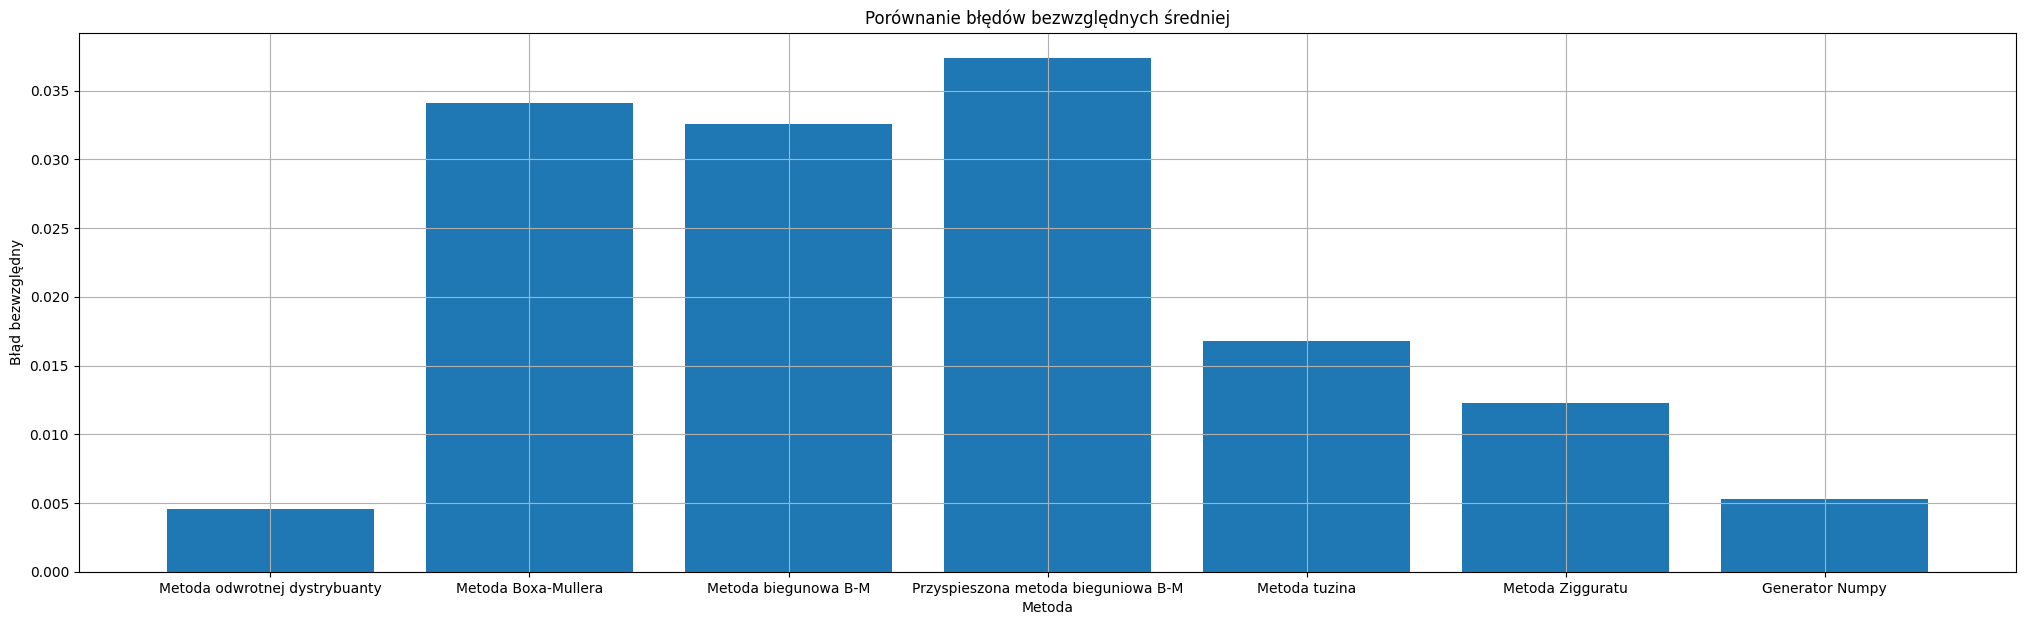

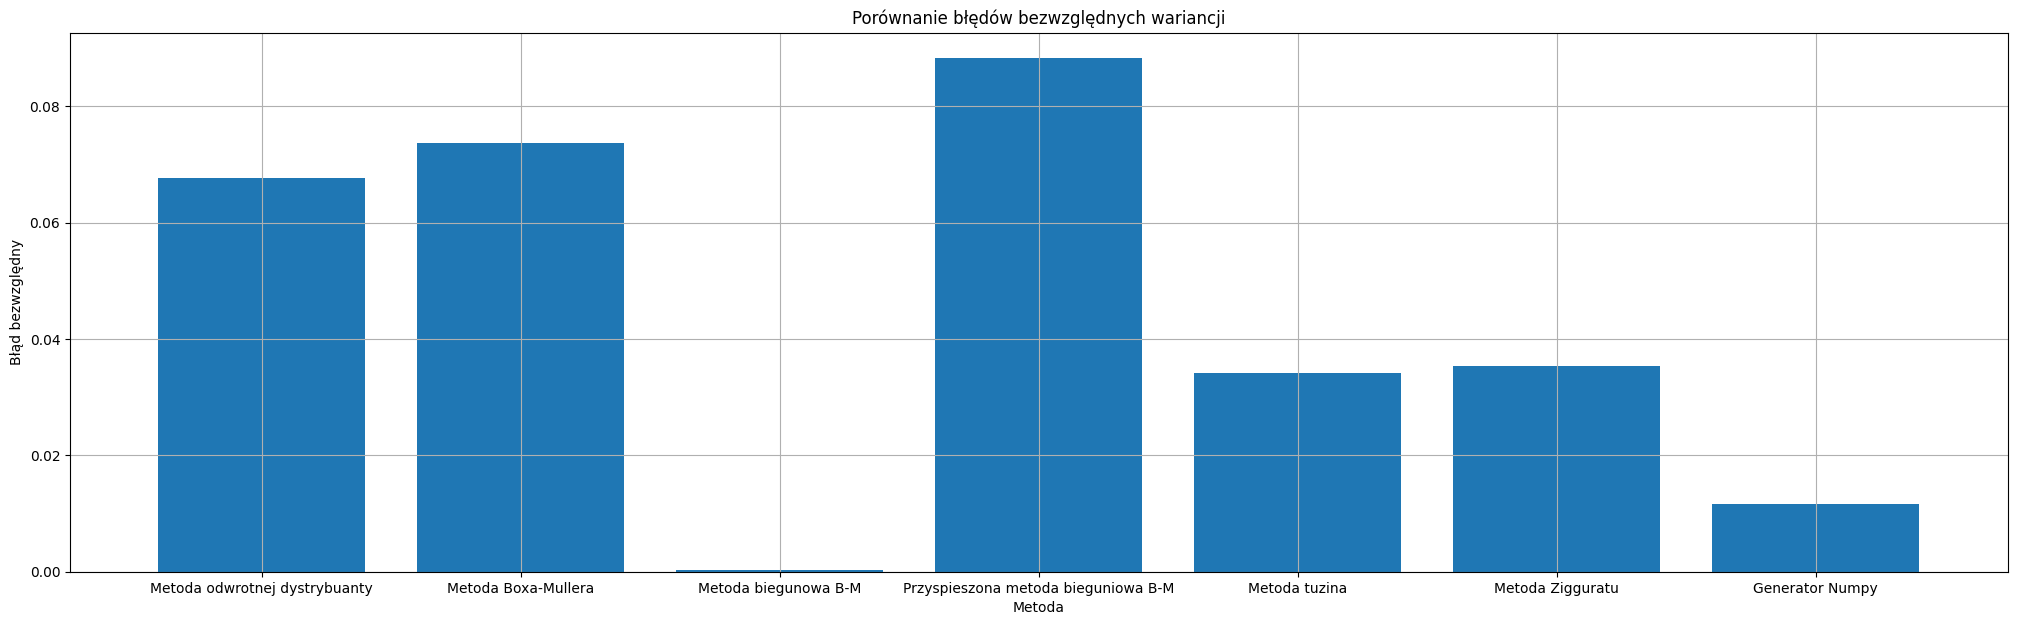

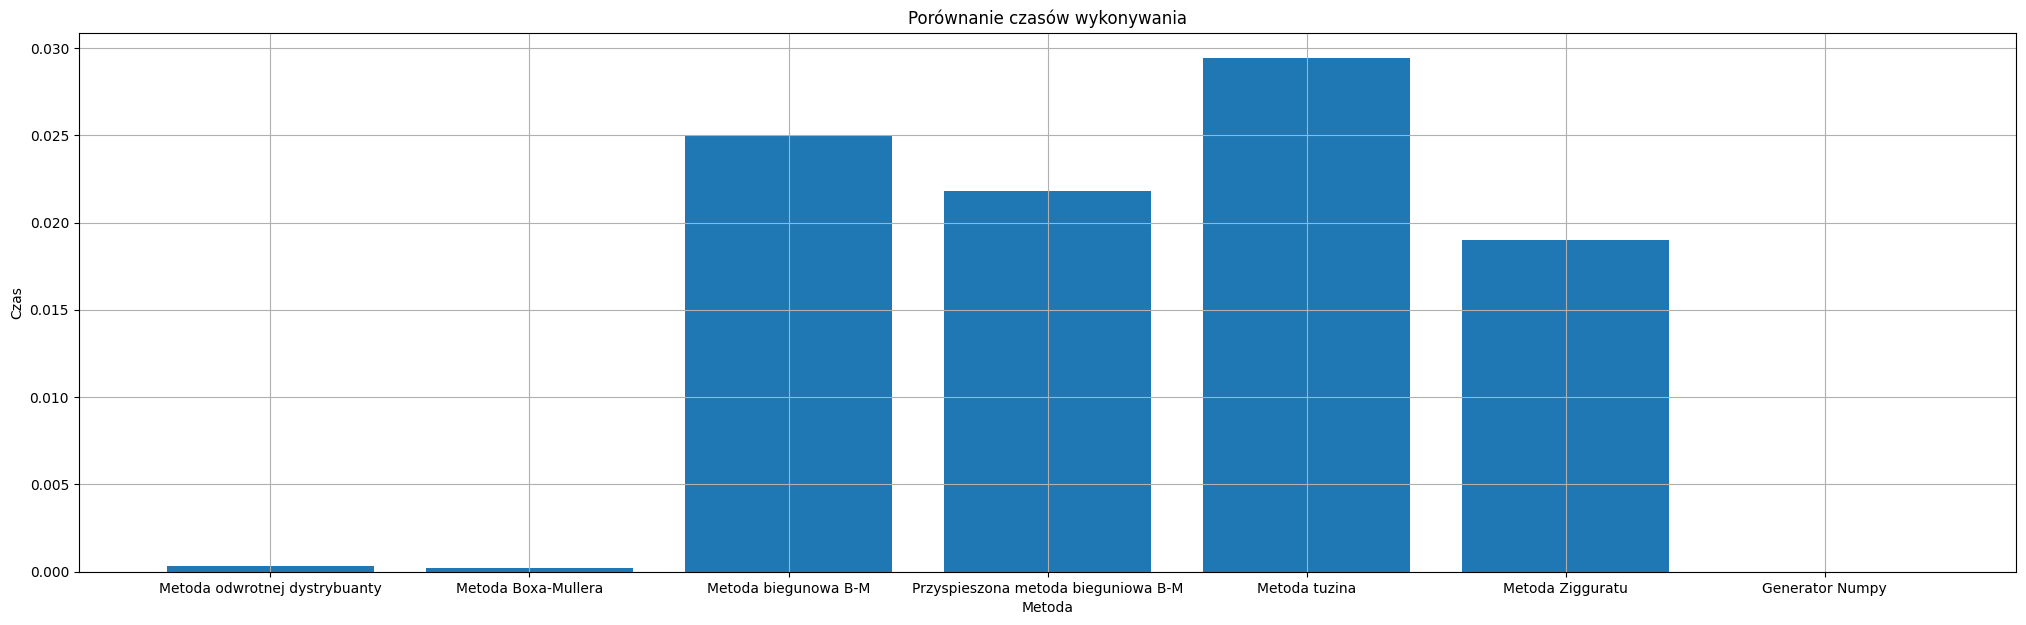

In [46]:
mean_np = np.mean(generated_numpy)
mean_1 = np.mean(generated_normal)
mean_box_muller = np.mean(x1)
mean_polar_box_muller = np.mean(x2)
mean__fast_polar_box_muller = np.mean(x3)
mean_tuzin = np.mean(tuzin_sample)
mean_ziggurat = np.mean(generated_ziggurat)

var_np = np.var(generated_numpy)
var_1 = np.var(generated_normal)
var_box_muller = np.var(x1)
var_polar_box_muller= np.var(x2)
var__fast_polar_box_muller = np.var(x3)
var_tuzin = np.var(tuzin_sample)
var_ziggurat = np.var(generated_ziggurat)


names = ['Metoda odwrotnej dystrybuanty','Metoda Boxa-Mullera','Metoda biegunowa B-M','Przyspieszona metoda bieguniowa B-M','Metoda tuzina','Metoda Zigguratu','Generator Numpy']
means = [mean_1,mean_box_muller,mean_polar_box_muller,mean__fast_polar_box_muller,mean_tuzin,mean_ziggurat,mean_np]
variances = [var_1,var_box_muller,var_polar_box_muller,var__fast_polar_box_muller,var_tuzin,var_ziggurat,var_np]
times = [time1,time_box_muller,time_polar_box_muller,time_fast_box_muller,time_tuzin, time_zigg,time_np]

errors_mean = []
errors_var = []
for mean in means:
    errors_mean.append(abs(mean - mu))

for var in variances:
    errors_var.append(abs(var - sigma))


data = {
    'Metoda': names,
    'Średnia': means,
    'Wariancja': variances,
    'Czas': times,
    'Błąd bezwzględny średniej': errors_mean,
    'Błąd bezwzględny wariancji': errors_var
}


df = pd.DataFrame(data)
df.index = df.index + 1
display(df)

plt.figure(figsize=(25,7))
plt.bar(names,errors_mean)
plt.title("Porównanie błędów bezwzględnych średniej")
plt.xlabel("Metoda")
plt.ylabel("Błąd bezwzględny") 
plt.grid(True)
plt.show()

plt.figure(figsize=(25,7))
plt.bar(names,errors_var)
plt.title("Porównanie błędów bezwzględnych wariancji")
plt.xlabel("Metoda")
plt.ylabel("Błąd bezwzględny") 
plt.grid(True)
plt.show()

plt.figure(figsize=(25,7))
plt.bar(names,times)
plt.title("Porównanie czasów wykonywania")
plt.xlabel("Metoda")
plt.ylabel("Czas") 
plt.grid(True)
plt.show()



## Wnioski
Przeprowadzone testy zgodności Kolmogorova-Smirnova oraz Shapiro-Wilka sugerują, że wszystkie z przetestowanych metod są skuteczne w generowaniu próbek z rozkładu normalnego. 

Dla odpowiednio dużej liczby próbek, wykresy dystrybuant empirycznych oraz gęstości empirycznych są praktycznie nieodróżnialne od ich teoretycznych odpowiedników.

Analizując tabelę porównawczą oraz wykresy słupkowe, możemy zauważyć, że wbudowany generator w pakiecie NumPy wyróżnia się jako najszybszy spośród badanych metod. Metody oparte na odwrotnej dystrybuancie oraz Boxa-Mullera również prezentują się dobrze, chociaż ich szybkość generowania próbek jest nieco gorsza.

Niektóre z metod wykazują nieznacznie większe błędy średniej i wariancji, jednakże są one na tyle małe, że nie mają istotnego wpływu na analizę rozkładu normalnego.

Ostatecznie, najlepszym wyborem spośród badanych generatorów okazuje się być wbudowana funkcja w pakiecie NumPy. Jest to spowodowane jej szybkością oraz niewielkimi błędami średniej i wariancji. Drugim najlepszym wyborem jest metoda Boxa-Mullera, ze względu na szybkość generowania próbek i niewielkie błędy.

Podsumowując, zarówno wbudowany generator w NumPy, jak i metoda Boxa-Mullera, są godnymi polecenia rozwiązaniami do generowania próbek z rozkładu normalnego, uwzględniając zarówno ich szybkość, jak i dokładność.



___
# $\text{Zadanie 3 - Metody redukcji wariancji.}$

## Krok 1 - metodą Monte Carlo oblicz całkę 
$$
\int_0^1 \frac{4}{1 + x^2} \, dx
$$
(szacowanie liczby $\pi$).

Na początku definiujemy funkcję, którą chcemy całkować.

In [92]:
def func(x):
    return 4 / (1 + x ** 2)

Metoda Monte Carlo do obliczania całki polega na losowym próbkowaniu punktów z przedziału całkowania. Poniżej zaimplementowana funkcja `monte_carlo_integrate` generuje próbki `x_samples` z rozkładu jednostajnego na przedziale $[a, b]$ za pomocą `np.random.uniform(a, b, num_points)`. Następnie dla każdego z tych punktów obliczana jest wartość funkcji $f(x)$ poprzez `func(x_samples)`, a średnia wartość funkcji `f_x` jest obliczana za pomocą `np.mean(f_x)`. Ostatecznie wartość całki jest uzyskiwana przez pomnożenie tej średniej przez długość przedziału $(b - a)$. 

In [96]:
def monte_carlo_integrate(func, a, b, num_points):
    x_samples = np.random.uniform(a, b, num_points)

    f_x = func(x_samples)
    average = np.mean(f_x)

    return average * (b - a)

Używamy powyższej funkcji do oszacowania całki dla zadanej funkcji na przedziale $[0, 1]$ przy użyciu $10,000$ punktów.

In [106]:
a = 0
b = 1
n = 10000
result = monte_carlo_integrate(func, a, b, n)
print("Wynik:", result)

Wynik: 3.1379782463265347


### Krok 2 - stosujemy metodę redukcji wariancji do ponownego obliczenia zadanej całki. 
 My wybieramy metodę odbić lustrzanych - antithetic variates.

Polega ona na tym, że dla każdej wygenerowanej próbki $ \{ x_1, \ldots, x_N \} $ bierzemy również jej antytetyczną próbkę $ \{ 1 - x_1, \ldots, 1 - x_N \} $. 

Zaletą tej techniki jest to, że:

1. Zmniejsza liczbę potrzebnych próbek, aby uzyskać $ N $ ścieżek.
2. Redukuje wariancję wyników symulacji, poprawiając precyzję.

W naszym zadaniu, chcemy oszacować wartość całki $ \theta $, czyli:

$$ \theta = \mathbb{E}(h(X)) = \mathbb{E}(Y)   $$

gdzie $ h(X) $ to nasza funkcja podcałkowa. Generujemy dwie próbki: 

- $ Y_1 $ - wartości funkcji dla losowych próbek
- $ Y_2 $ - wartości funkcji dla antytetycznych próbek

Następnie, obliczamy nieobciążone oszacowanie $ \theta $ za pomocą wzoru:

$$ \hat{\theta} = \frac{Y_1 + Y_2}{2} $$

Wariancja tego oszacowania jest dana wzorem:

$$ \text{Var}(\hat{\theta}) = \frac{\text{Var}(Y_1) + \text{Var}(Y_2) + 2\text{Cov}(Y_1, Y_2)}{4} $$

Dzięki temu, że próbki $ Y_1 $ i $ Y_2 $ są antytetyczne, kowariancja $ \text{Cov}(Y_1, Y_2) $ jest ujemna, co prowadzi do redukcji wariancji. To z kolei poprawia dokładność naszego oszacowania całki. 

Poniżej zaimplementowana funkcja `monte_carlo_antithetic` generuje próbki `x_samples` z rozkładu jednostajnego na przedziale $[a, b]$ za pomocą `np.random.uniform(a, b, half_points)`, gdzie `half_points` to połowa liczby całkowitych próbek `num_points`. Następnie generowane są próbki antytetyczne `antithetic_samples` jako `a + b - x_samples`. Dla obu zestawów próbek obliczane są wartości funkcji $f(x)$ poprzez `func(x_samples)` i `func(antithetic_samples)`. Średnia z tych wartości jest obliczana za pomocą `np.mean((f_x + f_x_antithetic) / 2)`. Ostatecznie wartość całki jest uzyskiwana przez pomnożenie tej średniej przez długość przedziału $(b - a)$.


In [103]:
def monte_carlo_antithetic(func, a, b, num_points):
    half_points = num_points // 2
    
    x_samples = np.random.uniform(a, b, half_points)
    
    antithetic_samples = a + b - x_samples  # Odbicia lustrzane
    
    f_x = func(x_samples)

    f_x_antithetic = func(antithetic_samples)
    
    average = np.mean((f_x + f_x_antithetic) / 2)
    
    return average * (b - a)

Używamy powyższej funkcji do ponownego oszacowania całki dla zadanej funkcji na przedziale $[0, 1]$ przy użyciu $10,000$ punktów.

In [107]:
result_antithetic = monte_carlo_antithetic(func, a, b, n)
print("Wynik za pomocą metody odbić lustrzanych:", result_antithetic)

Wynik za pomocą metody odbić lustrzanych: 3.1416355534507208


### Krok 3 - analiza błędu względem ilości symulacji dla obu metod.

W tym kroku wykonamy analizę błędu, obliczając błąd bezwzględny dla obu metod w zależności od rozmiaru próbek. Błąd bezwzględny jest różnicą między oszacowaną wartością całki a dokładną wartością (którą w tym przypadku jest $\pi$).

Po obliczeniu błędów dla różnych rozmiarów próbek, wyniki zostaną przedstawione w tabeli porównawczej.

In [65]:
sample_sizes = [100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 75000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000]

results_antithetic = {"Rozmiar Próbki": [], "Szacowanie MC (odbicia lustrzane)": [], "Błąd bezwzględny (odbicia lustrzane)": []}
results_plain_mc = {"Rozmiar Próbki": [], "Szacowanie MC (zwykłe)": [], "Błąd bezwzględny (zwykły)": []}

for n in sample_sizes:
    estimate_antithetic = monte_carlo_antithetic(func, 0, 1, n)
    absolute_error_antithetic = np.abs(estimate_antithetic - np.pi)
    results_antithetic["Rozmiar Próbki"].append(n)
    results_antithetic["Szacowanie MC (odbicia lustrzane)"].append(estimate_antithetic)
    results_antithetic["Błąd bezwzględny (odbicia lustrzane)"].append(absolute_error_antithetic)

    estimate_plain = monte_carlo_integrate(func, 0, 1, n)
    absolute_error_plain = np.abs(estimate_plain - np.pi)
    results_plain_mc["Rozmiar Próbki"].append(n)
    results_plain_mc["Szacowanie MC (zwykłe)"].append(estimate_plain)
    results_plain_mc["Błąd bezwzględny (zwykły)"].append(absolute_error_plain)

results_df = pd.DataFrame(results_antithetic)
results_plain_mc_df = pd.DataFrame(results_plain_mc)
comparison_df = pd.merge(results_plain_mc_df, results_df, on="Rozmiar Próbki")
comparison_df.index = comparison_df.index + 1
comparison_df

,Rozmiar Próbki,Szacowanie MC (zwykłe),Błąd bezwzględny (zwykły),Szacowanie MC (odbicia lustrzane),Błąd bezwzględny (odbicia lustrzane)
1,100,3.070908,0.070685,3.141486,0.000107
2,200,3.186398,0.044805,3.142288,0.000695
3,300,3.129075,0.012518,3.138319,0.003274
4,400,3.154538,0.012946,3.134205,0.007387
5,500,3.117330,0.024263,3.141832,0.000240
6,1000,3.135648,0.005944,3.137680,0.003912
7,2000,3.156734,0.015141,3.141089,0.000504
8,3000,3.139578,0.002015,3.141292,0.000301
9,4000,3.136027,0.005565,3.141089,0.000504
10,5000,3.142483,0.000891,3.141938,0.000345


Na koniec tworzymy wykres porównawczy, który przedstawi błędy bezwzględne dla obu metod w zależności od rozmiaru próbek.

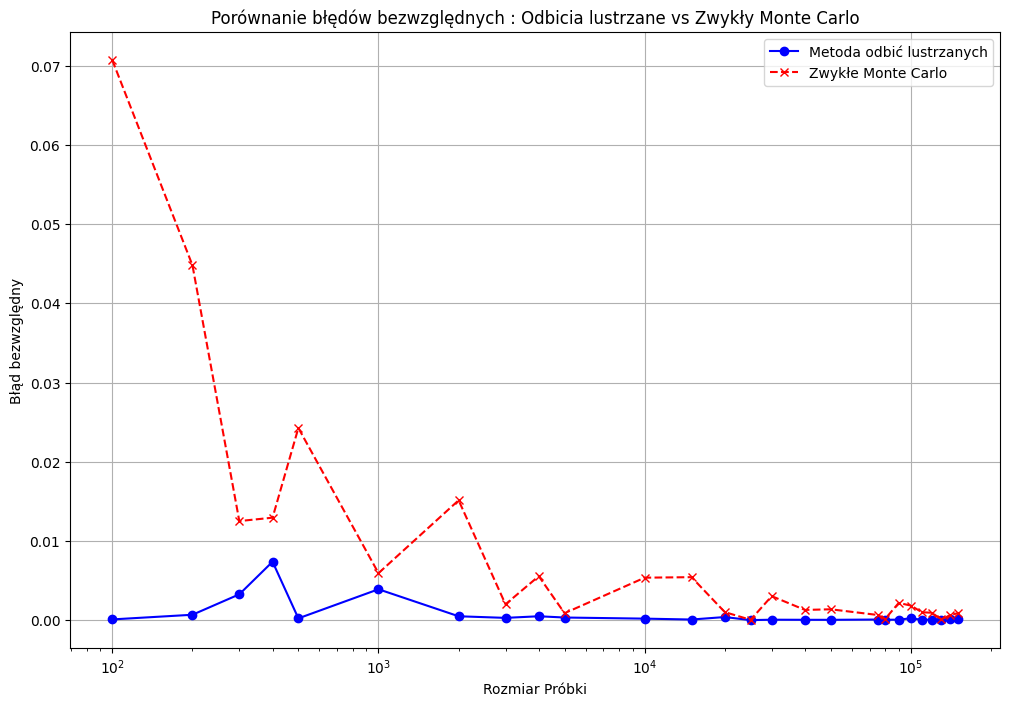

In [66]:
plt.figure(figsize=(12, 8))
plt.plot(comparison_df["Rozmiar Próbki"], comparison_df["Błąd bezwzględny (odbicia lustrzane)"], marker='o', linestyle='-', color='b', label='Metoda odbić lustrzanych')
plt.plot(comparison_df["Rozmiar Próbki"], comparison_df["Błąd bezwzględny (zwykły)"], marker='x', linestyle='--', color='r', label='Zwykłe Monte Carlo')
plt.title("Porównanie błędów bezwzględnych : Odbicia lustrzane vs Zwykły Monte Carlo")
plt.xlabel("Rozmiar Próbki")
plt.ylabel("Błąd bezwzględny")
plt.xscale("log")  
plt.legend()
plt.grid(True)
plt.show()

#### Wnioski z analizy porównawczej metod Monte Carlo
1. **Skuteczność metody redukcji wariancji**:
Metoda z odbiciami lustrzanymi konsekwentnie generuje mniejsze błędy bezwzględne na wszystkich poziomach próbkowania. Pokazuje to wyraźnie skuteczność tej metody w redukcji wariancji w porównaniu do standardowej metody Monte Carlo.

2. **Stabilność metod:**
Metoda z odbiciami lustrzanymi wykazuje znacznie mniejsze fluktuacje błędów między różnymi poziomami próbkowania, co sugeruje większą stabilność tej metody w różnych warunkach symulacyjnych.

3. **Efektywność w zastosowaniach:**
Wyższa precyzja metody z odbiciami lustrzanymi może być decydująca w zastosowaniach wymagających wysokiej dokładności obliczeń.

**Podsumowanie:**
Metoda Monte Carlo z odbiciami lustrzanymi jest preferowanym wyborem, gdy kluczowe jest zmniejszenie wariancji i zwiększenie precyzji estymacji.

___
## $\text{Zadanie 4 - warunkowa wartość oczekiwana.}$

• Jeśli $X$, $Y$ są zmiennymi niezależnymi a $E(Y) = 0$, to dla $Z = XY + \sin(X)$ zachodzi $E(Z|X) = \sin(X)$. Jako przykład można wziąć np. $X, Y \sim N(0, 1)$.

In [30]:
np.random.seed(0)

n = 200
M = 1000

Generujemy $n$ próbek z rozkładu normalnego, usuwamy duplikaty i sortujemy. Tworzymy macierz Z_values do przechowywania wyników $Z$ oraz X_values do powielania wartości $X$.

In [31]:
X = np.random.normal(0, 1, n)
X = np.unique(X) 
X = np.sort(X)
n = len(X) 

Z_values = np.zeros(n * M)
X_values = np.repeat(X, M)

Iterujemy przez każdą wartość $x_i$ w wektorze $X$, generujemy M próbek $Y$ z rozkładu normalnego $N(0, 1)$ i obliczamy wartości $Z$ według wzoru $Z = x_i \cdot Y + \sin(x_i)$. Wyniki obliczeń przechowujemy w macierzy z_values w odpowiednich miejscach, gdzie i * M jest indeksem początkowym dla $Z$ wartości odpowiadających $x_i$, a (i + 1) * M jest indeksem końcowym dla $Z$ wartości odpowiadających $x_i$.

In [33]:
for i, x_i in enumerate(X):
    Y = np.random.normal(0, 1, M) 
    Z_values[i * M:(i + 1) * M] = x_i * Y + np.sin(x_i)  

Dla każdej wartości $x_i$ obliczamy średnią wartość $Z$, tworząc listę średnich wartości $Z$ dla każdej wartości $X$. 

Na koniec tworzymy wykres, który pokazuje symulowane wartości $Z|X$ oraz teoretyczne wartości  $E(Z|X) = \sin(X)$  i empiryczne $E(Z|X)$.

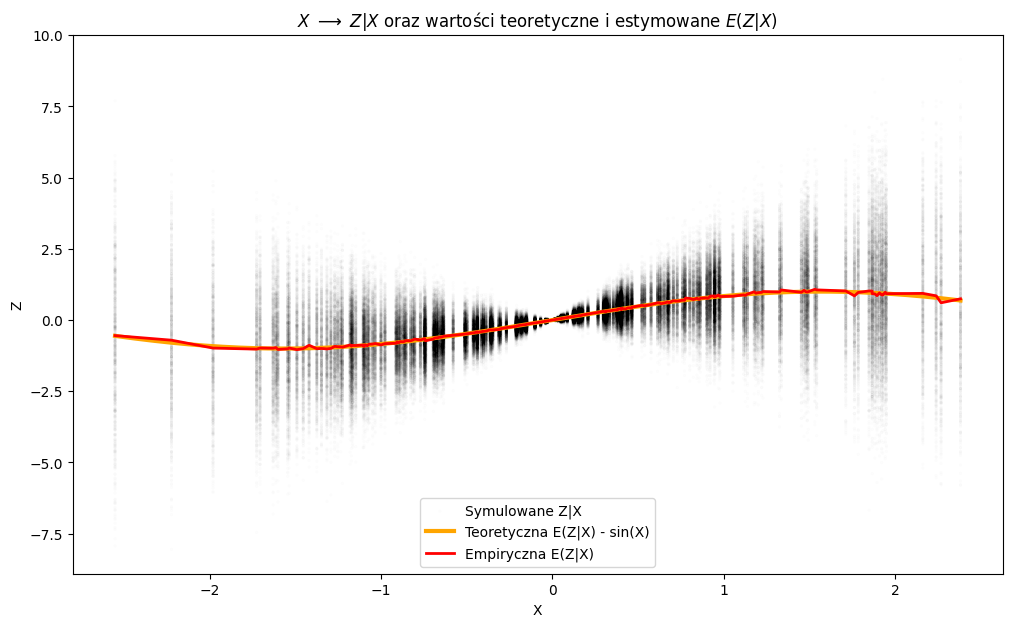

In [34]:
Z_means = np.array([np.mean(Z_values[i * M:(i + 1) * M]) for i in range(n)])

x_range = np.linspace(np.min(X), np.max(X), 300)

plt.figure(figsize=(12, 7))
plt.scatter(X_values, Z_values, color='gray', alpha=0.01, facecolors='none', edgecolors='black', s=2, label='Symulowane Z|X')
plt.plot(x_range, np.sin(x_range), color='orange', label='Teoretyczna E(Z|X) - sin(X)', linewidth=3)
plt.plot(X, Z_means, color='red', label='Empiryczna E(Z|X)', linewidth=2)
plt.xlabel('X')
plt.ylabel('Z')
plt.title('$X$ $\\longrightarrow$ $Z|X$ oraz wartości teoretyczne i estymowane $E(Z|X)$')
plt.legend()
plt.show()

### Teoretyczna wartość $E(Z \mid X) = \sin(X)$ jest zgodna z symulowanymi danymi, co widać na wykresie, gdzie krzywa teoretyczna $\sin(X)$ (pomarańczowa linia) dobrze aproksymuje średnią z symulowanych danych. Empiryczne wartości $E(Z \mid X)$ (czerwona linia) również dobrze przybliżają teoretyczne wartości, co potwierdza poprawność symulacji.

<hr>

• Gdy $N$ jest procesem Poissona o intensywności $\lambda$, to dla $T \geq t \ge 0$ zachodzi $E(N_t|N_T) = \frac{t N_T}{T}$. Oznacza to, że np. zakładając przybywanie klientów do sklepu zgodnie z procesem Poissona i mając dane na temat dotychczasowej ilości klientów w sklepie w chwili $T$ (czyli $N_T$), to najlepszym przybliżeniem dotychczasowej ilości klientów w chwili $t < T$ równej $N_t$ jest $\frac{t N_T}{T}$.

Na początku definiujemy parametry symulacji: czas $T$, liczbę kroków czasowych, liczbę kroków Monte Carlo.

In [38]:
T = 1
monte_carlo_steps = 100
time_steps = 1000
time_range = np.linspace(0, T, time_steps)

Następnie tworzymy funkcję `get_poisson_process`, która symuluje proces Poissona poprzez generowanie $k$ zdarzeń Poissona w przedziale $[a, b]$. Funkcja wykorzystuje rozkład jednostajny do generowania losowych czasów zdarzeń, a następnie sortuje te czasy rosnąco. Dzięki temu uzyskamy realistyczne czasy przyjścia klientów zgodnie z procesem Poissona, gdzie zdarzenia są niezależne i występują z jednakowym prawdopodobieństwem w dowolnym momencie w zadanym przedziale czasowym.

In [39]:
def get_poisson_process(a, b, k):
    return np.sort(np.random.uniform(a, b, k))

W funkcji `simulate_clients` najpierw tworzymy macierz clients_over_time, która przechowuje liczbę klientów w każdym kroku symulacji. Następnie iterujemy przez każdy krok Monte Carlo, generując losowe czasy przyjścia klientów za pomocą funkcji `get_poisson_process`, która zwraca posortowane czasy przyjścia klientów w zadanym przedziale czasowym. Dla każdego punktu czasowego w time_range liczymy liczbę klientów, którzy przyszli do tego momentu. Na koniec obliczamy średnią liczbę klientów w każdym punkcie czasowym, co pozwala uzyskać oczekiwaną liczbę klientów w czasie.

In [40]:
def simulate_clients(T, N_T, time_range, monte_carlo_steps):
    clients_over_time = np.zeros((monte_carlo_steps, len(time_range)))

    for i in range(monte_carlo_steps):
        arrival_times = get_poisson_process(0, T, N_T)
        for j, t in enumerate(time_range):
            clients_over_time[i, j] = np.sum(arrival_times <= t)

    expected_clients = np.mean(clients_over_time, axis=0)
    return expected_clients


Tworzymy wykres porównujący teoretyczne wartości $E(N_t | N_T) = \frac{t \cdot N_T}{T}$ oraz empiryczne wartości $E(N_t | N_T)$ oczekiwanej liczby klientów dla różnych wartości $N_T$.


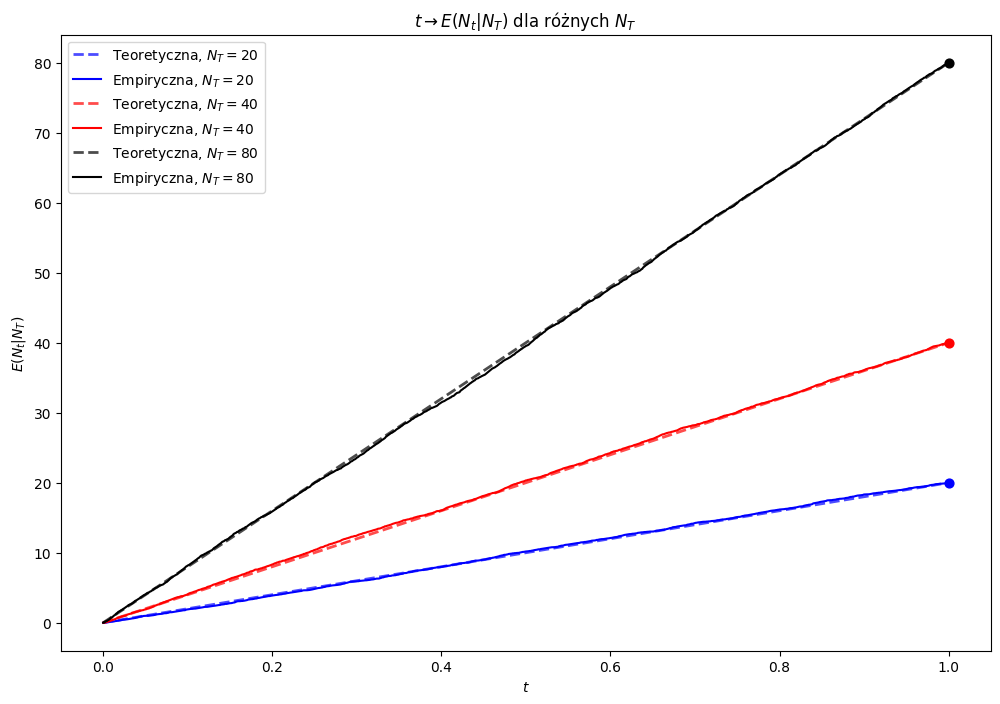

In [41]:
N_Ts = [20, 40, 80]
colors = ['blue', 'red', 'black']
plt.figure(figsize=(12, 8))

for index, N_T in enumerate(N_Ts):
    expected_clients = simulate_clients(T, N_T, time_range, monte_carlo_steps)

    plt.plot(time_range, (time_range * N_T) / T, '--', linewidth=2, c=colors[index], alpha=0.7, label=f"Teoretyczna, $N_T = {N_T}$")
    plt.plot(time_range, expected_clients, label=f"Empiryczna, $N_T = {N_T}$", c=colors[index])
    plt.scatter([T], [N_T], c=colors[index], s=40)

plt.title('$t \\rightarrow E(N_t|N_T)$ dla różnych $N_T$')
plt.xlabel('$t$')
plt.ylabel('$E(N_t|N_T)$')
plt.legend()
plt.show()

### Wartości empiryczne dobrze aproksymują teoretyczne wartości, co potwierdza zgodność symulacji z teoretycznymi przewidywaniami. Dla różnych wartości $N_T$ wykresy pokazują, że liczba klientów rośnie liniowo wraz z czasem, co jest zgodne z oczekiwaniami dla procesu Poissona.

<hr>

• Gdy $N$ jest procesem Poissona o intensywności $\lambda$, to dla $t \geq s \geq 0$ zachodzi $\mathbb{E}(N_t|\mathcal{F}_s) = N_s + \lambda(t - s)$, gdzie $\mathcal{F}_s$ to filtracja naturalna procesu $N_s$. Oznacza to, że np. zakładając przybywanie klientów do sklepu zgodnie z procesem Poissona i mając dane na temat dotychczasowej ilości klientów w sklepie w każdej chwili $\omega$ spełniającej $0 \leq \omega \leq s$ (czyli $\mathcal{F}_s$), to najlepszym przybliżeniem dotychczasowej chwili klientów w chwili $t \geq s$ jest $N_s + \lambda(t - s)$.


Definiujemy parametry nowej symulacji: intensywność $\lambda$, czas $s$, całkowity czas $T$. Liczba kroków czasowych oraz liczba kroków Monte Carlo pozostają takie same.

In [62]:
lambda_value = 10
s = 1
T = 2  # s <= t <= T
time_steps_count = 1000
monte_carlo_steps = 100
time_range = np.linspace(0, T, time_steps_count)

Funkcja `simulate_clients_with_past` różni się od funkcji `simulate_clients` używanej w drugiej kropce, ponieważ uwzględnia klientów, którzy przybyli przed określonym momentem w czasie $s$, oraz klientów, którzy przybywają po $s$. W funkcji `simulate_clients_with_past` najpierw tworzymy macierz clients_over_time, która przechowuje liczbę klientów w każdym kroku symulacji, podobnie jak w `simulate_clients`. Jednak w tej funkcji uwzględniamy dodatkowe zdarzenia, które miały miejsce przed $s$.

W każdym kroku Monte Carlo generujemy liczbę klientów $k$ przybyłych po $s$ korzystając z rozkładu Poissona o intensywności $\lambda$ dla przedziału czasu $(T-s)$. Następnie za pomocą funkcji `get_poisson_process` generujemy posortowane czasy przyjścia tych klientów w przedziale $[s, T]$.

Dla każdego punktu czasowego w time_range obliczamy łączną liczbę klientów, którzy przybyli do tego momentu, rozdzielając klientów, którzy przybyli przed $s$ i po $s$. Jeśli czas $t$ jest mniejszy lub równy $s$, łączna liczba klientów jest sumą tych, którzy przybyli do $t$ w przeszłości. Jeśli $t$ jest większy niż $s$, dodajemy do tego liczbę klientów, którzy przybyli po $s$ do $t$.

Na koniec obliczamy średnią liczbę klientów w każdym punkcie czasowym, co pozwala uzyskać oczekiwaną liczbę klientów w czasie. 

In [63]:
def simulate_clients_with_past(s, T, N_s, F_s, time_range, monte_carlo_steps):
    clients_over_time = np.zeros((monte_carlo_steps, len(time_range)))

    for i in range(monte_carlo_steps):
        k = poisson.rvs(mu=lambda_value * (T - s))
        N_t = get_poisson_process(s, T, k)
        total_clients = N_s
        current_index = 0

        for j, t in enumerate(time_range):
            if t <= s:
                total_clients = np.sum(F_s <= t)
            else:
                while current_index < len(N_t) and N_t[current_index] <= t:
                    total_clients += 1
                    current_index += 1
            clients_over_time[i, j] = total_clients

    expected_clients = np.mean(clients_over_time, axis=0)
    return expected_clients


Na wykresie porównujemy teoretyczne wartości oczekiwane $E(N_t \mid F_s)$ oraz wartości empiryczne uzyskane z symulacji, uwzględniając klientów przybyłych przed czasem $s$ oraz po czasie $s$.

Wykonujemy to dla trzech różnych wartości $N_s$.

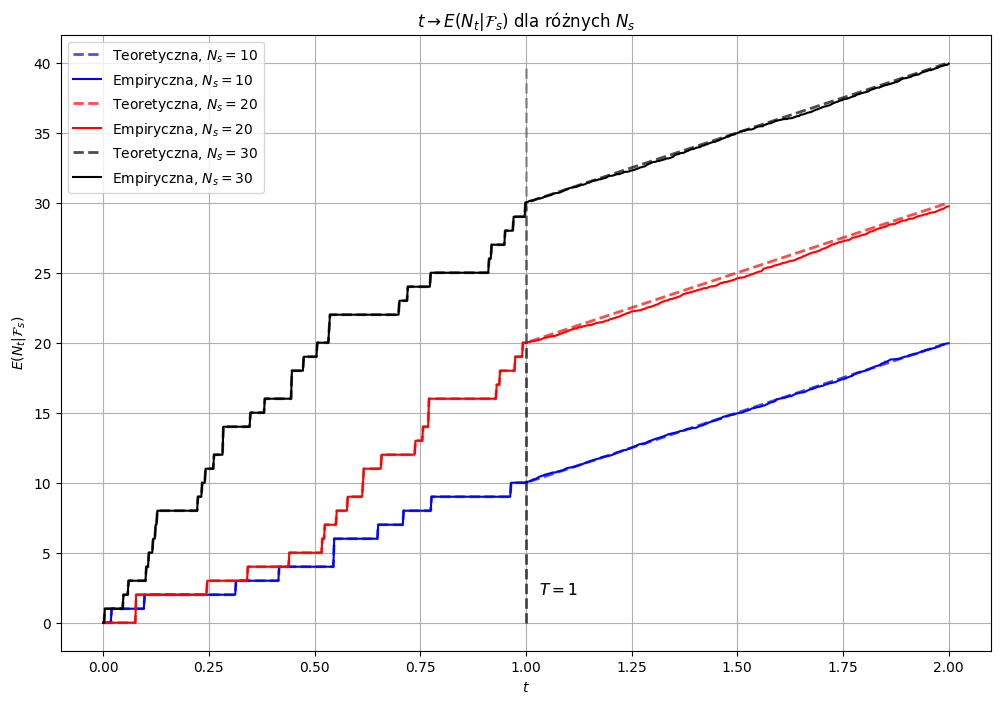

In [66]:
N_s_values = [10, 20, 30]  
colors = ['blue', 'red', 'black']

plt.figure(figsize=(12, 8))

for index, N_s in enumerate(N_s_values):
    F_s = get_poisson_process(0, s, N_s)
    expected_clients = simulate_clients_with_past(s, T, N_s, F_s, time_range, monte_carlo_steps)

    # Obliczanie wartości teoretycznych
    theoretical_values = np.zeros_like(time_range)
    for i, t in enumerate(time_range):
        if t <= s:
            theoretical_values[i] = np.sum(F_s <= t)
        else:
            theoretical_values[i] = N_s + lambda_value * (t - s)

    plt.vlines(x=s, ymin=0, ymax=np.max(expected_clients), linestyles='dashed', linewidth=2, color='black', alpha=0.3)
    plt.text(s * 1.03, 2, f"$T = {s}$", color='black', fontsize=11, alpha=0.6)

    # Teoretyczne
    plt.plot(time_range, theoretical_values, '--', linewidth=2, alpha=0.7, label=f"Teoretyczna, $N_s = {N_s}$", c=colors[index])
    # Empiryczne
    plt.plot(time_range, expected_clients, label=f"Empiryczna, $N_s = {N_s}$", c=colors[index])

plt.title('$t \\rightarrow E(N_t|\\mathcal{F}_s)$ dla różnych $N_s$')
plt.xlabel('$t$')
plt.ylabel('$E(N_t|\\mathcal{F}_s)$')
plt.legend()
plt.grid(True)
plt.show()


### Wartości empiryczne dobrze aproksymują teoretyczne wartości, co potwierdza zgodność symulacji z teoretycznymi przewidywaniami. Wykresy pokazują, że liczba klientów rośnie wraz z czasem, uwzględniając zarówno klientów z przeszłości, jak i tych przybywających po czasie $s$.

___ 
# $ \text{Zadanie 5 - Czas ruiny} $
Niech $X_t$ będzie procesem ruiny modelu Craméra-Lundberga
$$
    X_t = u + ct − \sum _{i=0}^{N_t} ξ_i,
$$
gdzie $ t,c,u ≥ 0, ξ_i ∼ \text{Exp}(η), ξ_i$ ⊥ $ξ_j$ dla $i \neq j, \mathrm{E}(ξ_i) = η, $ a $N_t$ jest procesem Poissona o intensywności λ. Czasem
ruiny klasycznej nazywamy zmienną τ = inf{ t > 0 | Xt < 0 }. Prawdopodobieństwem ruiny w czasie nieskończonym
nazywamy funkcję ψ(u,c) = P (τ < ∞). Wzór Pollaczka-Chinczyna mówi, że
$$
ψ(u, c) =\frac{ηλ}{c} e^{−(\frac{1}{η} − \frac{\lambda}{c})u},
$$
Zweryfikowano symulacyjnie ten wynik. W tym celu skorzystano z pomocniczego prawdopodobieństwa ruiny w czasie skończonym T, tj. Ψ(u,c,T) = P (τ < T), T > 0, dla odpowiednio dużego T. Aby to uzyskać przeprowadzono symulację metodą Monte Carlo. 
Na początku ustalono potrzebne parametry oraz ilość symulacji.

In [2]:
T_horizon = 10
lambda_ = 1
eta = 1
MC = 1000

Następnie zaimplementowano funkcję `simulate_ruin(u, c)`, która zasymuluje proces ruiny.

In [3]:
def simulate_ruin(u, c):
    time = 0
    while time <= T_horizon:
        t = np.random.exponential(1/lambda_)
        time += t
        loss = np.random.exponential(1/eta)
        u = u + c*t - loss
        if u <= 0:
            return 1
    return 0

Kolejnym krokiem było zaimplementowanie funkcji `pollaczek_chinczyn(u,c)`, która obliczy prawdopodobieństwo zgodnie ze wzorem Pollaczka-Chinczyna.

In [4]:
def pollaczek_chinczyn(u,c):
    return ((eta*lambda_)/c) * np.exp(-( (1/eta) - (lambda_/c) )* u) 

Następnie zaimplementowano funkcję `probability(u,c)`, która obliczy prawdopodobieństwo ruiny.

In [5]:
def probability(u,c):
    if c <= lambda_ * eta:
        return 1
    ruins = [simulate_ruin(u, c) for _ in range(MC)]
    return  np.mean(ruins)

Jako pierwsze zostaną obliczone prawdopodobieństwa ruiny dla stałych wartościach wskaźnika przyrostu i zmiennych kapitałach początkowych. Do zobrazowania wyników przyjęto $c \in \{2,5,10\} $ oraz 100 wartości u z przedziału [1,20]. 

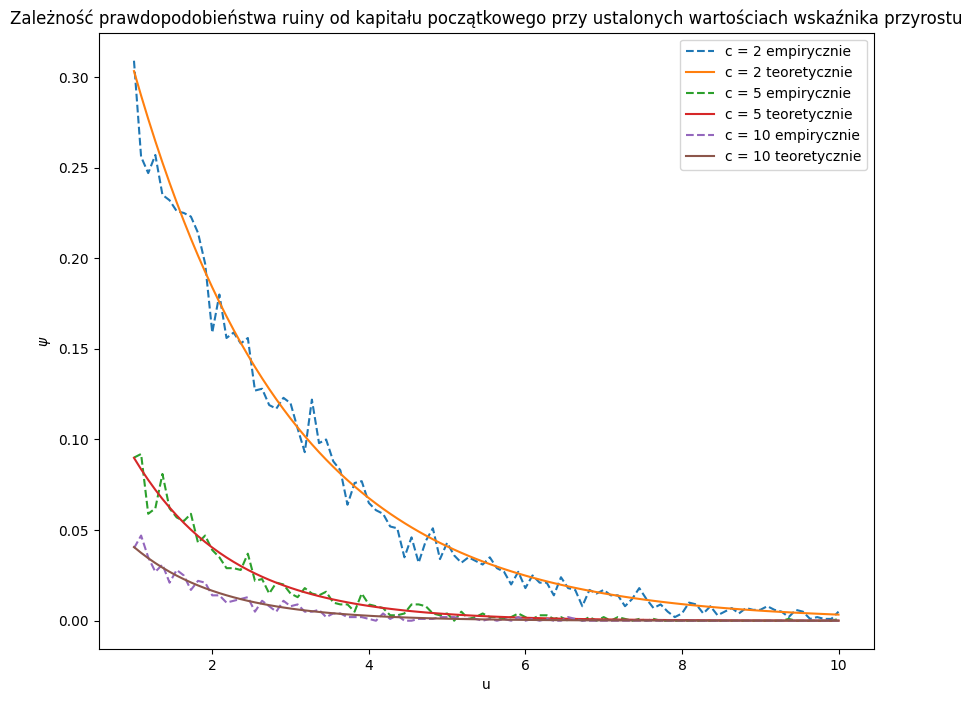

In [296]:
income = [2, 5, 10] 
initial_capital = np.linspace(1,10,100)

plt.figure(figsize=(10,8))
for c in income:
    probabilities = []
    teo_prob = []
    for u in initial_capital:
        p = probability(u,c)
        probabilities.append(p)
        pc = pollaczek_chinczyn(u,c)
        teo_prob.append(pc)
    plt.plot(initial_capital,probabilities,label = f'c = {c} empirycznie',linestyle='--')
    plt.plot(initial_capital,teo_prob,label = f'c = {c} teoretycznie')
plt.legend()
plt.title("Zależność prawdopodobieństwa ruiny od kapitału początkowego przy ustalonych wartościach wskaźnika przyrostu")
plt.xlabel("u")
plt.ylabel("$\psi$")
plt.show()

Następnie sprawdzono zachowanie prawdopodobieństwa dla stałych kapitałów początkowych, czyli w naszym przypadku $ u \in \{2,5,10\} $ oraz zmiennych wartości wskaźnika przychodów u, którymi będzie 100 liczb z przedziału [2,20].

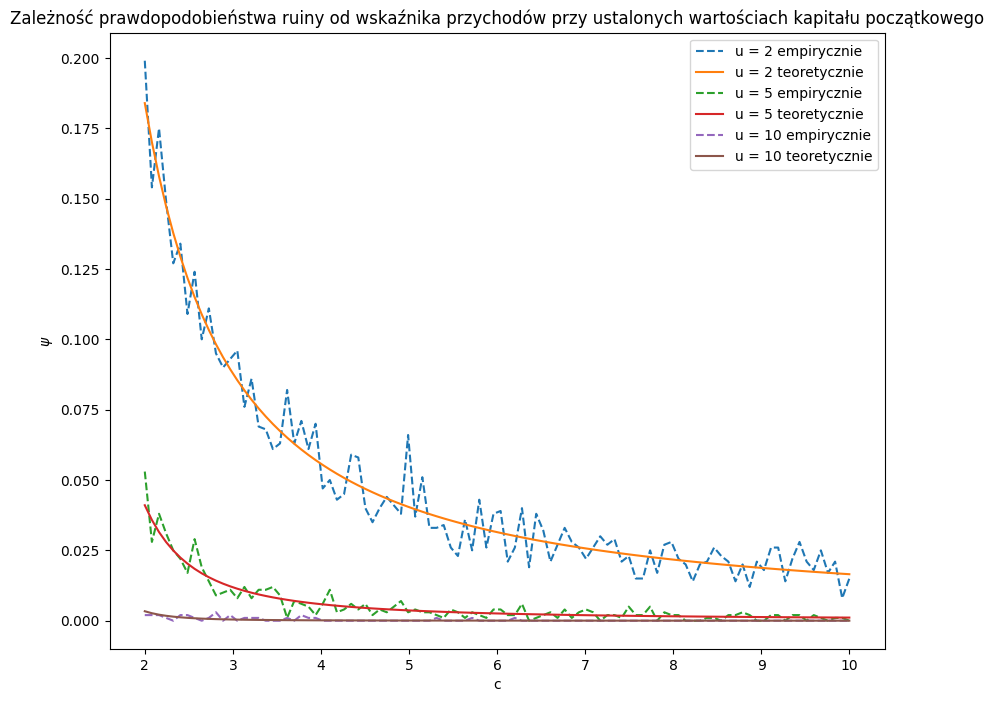

In [297]:
initial_capital = [2, 5, 10] 
income = np.linspace(2,10,100)

plt.figure(figsize=(10,8))
for u in initial_capital:
    probabilities = []
    teo_prob = []
    for c in income:
        p = probability(u,c)
        probabilities.append(p)
        pc = pollaczek_chinczyn(u,c)
        teo_prob.append(pc)
    plt.plot(income,probabilities,label = f'u = {u} empirycznie',linestyle='--')
    plt.plot(income,teo_prob,label = f'u = {u} teoretycznie')
plt.legend()
plt.title("Zależność prawdopodobieństwa ruiny od wskaźnika przychodów przy ustalonych wartościach kapitału początkowego")
plt.xlabel("c")
plt.ylabel("$\psi$")
plt.show()

Analizę powtórzono dla funkcji odwrotnej do funkcji ze wzoru Pollaczka-Chinczyna.
$$
c(u,ψ) = \frac{λu}{W_0 \left(\frac{u \psi e^{uη}}{η} \right)}
$$
gdzie W_0 to gałąź funkcji W Lamberta zdefiniowana poprzez równanie:
$$
 W_0(xe^x) = x \,\,\,\,\, \text{dla} \,\,\, x ≥0 
$$
Analiza ta odpowiada szukaniu wymaganej wartości wpłat przy danym kapitale początkowym w celu osiągnięcia wymaganego prawdopodobieństwa ruiny.
Pierwszym krokiem było zaimplementowanie funkcji $c(u,ψ)$.

In [11]:
def inv_pol_chin(u,psi):
    return np.real((lambda_*u) / (lambertw((u*psi*np.exp(u/eta))/eta)))

Następnie napisano funkcję ` estimate_c(u,psi) `, która wyliczy wyestymowaną wartość wskaźnika przychodów.

In [51]:
def estimate_c(u,psi):
    result = []
    low = psi * 0.95
    high = psi * 1.05
    c_test_values = np.linspace(0,3.5,1000)
    for c in c_test_values:
        p = probability(u,c)
        if (p >= low) and (p <= high):
            result.append(c)
    return np.mean(result)

Następnie dla ustalonych wartości prawdopodobieństwa ruiny $\psi$ , które w tym przypadku wynosić będą $\psi \in \{0.15 , 0.3 \} $ i ustalonych wartości kapitału początkowego $u$, stworzono wykresy, w celu porównania wartości wyestymowanych z teoretycznymi. 

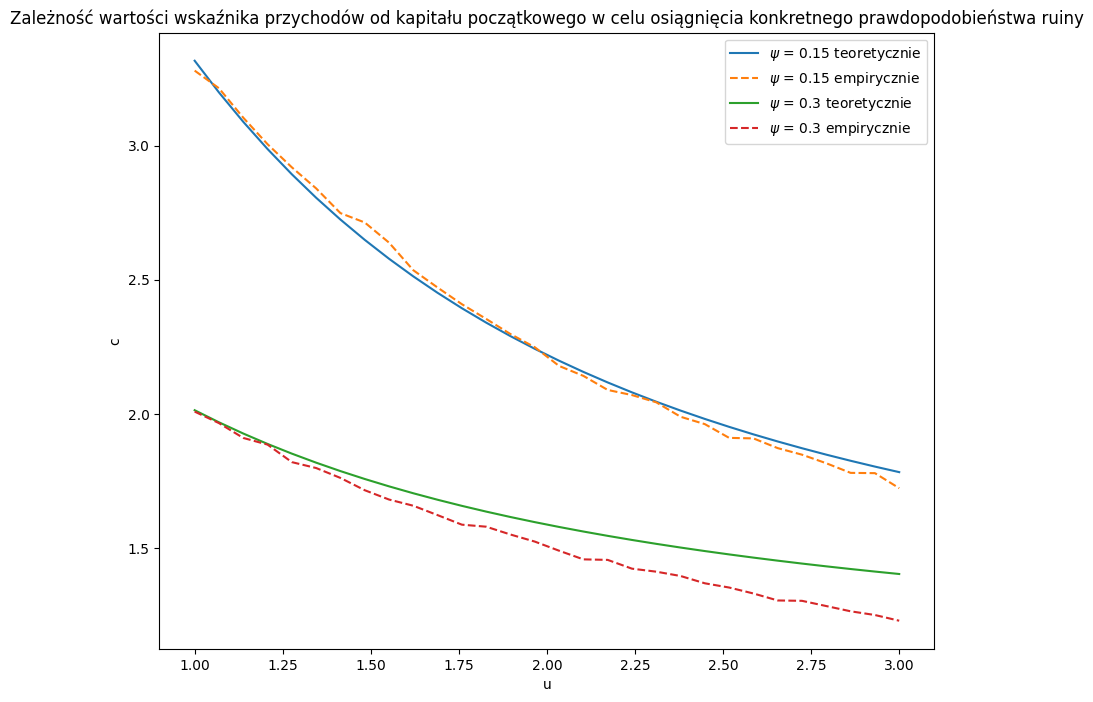

In [52]:
probabilities = [0.15,0.3] 
initial_capital = np.linspace(1,3,30)

plt.figure(figsize=(10,8))
for psi in probabilities:
    teo = []
    estimated = []
    for u in initial_capital:
        inv = inv_pol_chin(u,psi)
        teo.append(inv)
        est = estimate_c(u,psi)
        estimated.append(est)
    plt.plot(initial_capital, teo, label = f'$\psi$ = {psi} teoretycznie' )
    plt.plot(initial_capital, estimated,label = f'$\psi$ = {psi} empirycznie',linestyle='--')
plt.legend()
plt.title("Zależność wartości wskaźnika przychodów od kapitału początkowego w celu osiągnięcia konkretnego prawdopodobieństwa ruiny")
plt.xlabel("u")
plt.ylabel("c")
plt.show()

# Wnioski
Analizując przeprowadzone symulacje oraz stworzone wykresy, można wysunąć wniosek, że zarówno wzór Pollaczka-Chinczyna, jak i jego funkcja odwrotna są poprawne, a wartości empirycznie wyliczone nie różnią się znacząco od wartości teoretycznych.

Wygenerowane wykresy wyraźnie pokazują zależności między prawdopodobieństwem ruiny, kapitałem początkowym oraz współczynnikiem przychodów. Możemy zauważyć, że większy kapitał początkowy prowadzi do zmniejszenia prawdopodobieństwa ruiny, podobnie jak zwiększenie współczynnika przychodów. Dodatkowo, analiza ostatniego wykresu pozwala stwierdzić, że przy rosnącym kapitale początkowym, prawdopodobieństwo ruiny pozostaje stałe, jeśli odpowiednio zmniejszymy współczynnik przychodów.

Wnioski te mogą być używane do podejmowania decyzji zarządczych lub inwestycyjnych w celu optymalizacji wyników finansowych i minimalizacji ryzyka bankructwa. Dzięki analizie tych zależności, można lepiej zrozumieć, jak zmiany w kapitale początkowym i współczynniku przychodów mogą wpływać na stabilność finansową i ryzyko bankructwa. Jest to istotna wiedza przy podejmowaniu decyzji dotyczących alokacji kapitału i zarządzania ryzykiem w różnych dziedzinach biznesowych oraz inwestycyjnych.

___ 
# $\text{Zadanie 6 - Prawa arcusa sinusa}$
Ciągła zmienna losowa X ma rozkład arcusa sinusa $(X \sim \mathrm{Arcsine})$, gdy jej funkcja gęstości prawdopodobieństwa $pX$ ma postać:
$$ 
p_X(x) = \frac{1}{π\sqrt{x(1 −x)}} \mathbb{1}_{(0,1)}(x). 
$$
Dystrybuanta tej zmiennej losowej jest wtedy równa
$$
F_X(x) = 
\begin{cases}
0, \ \ \  x \lt 0, \\
\frac{2}{\pi}\arcsin(\sqrt{x}), \ \ \   x \in [0, 1], \\
1, \ \ \   x \gt 1.
\end{cases}
$$
Poniżej zaimplementowano obie funkcje.

In [92]:
def arc_sin_pdf(x):
    return [0 if xi >= 1 or xi <= 0 else 1/(np.pi * np.sqrt(xi*(1-xi))) for xi in x]


def arc_sin_cdf(x):
    return [0 if xi < 0 else 1 if xi > 1 else (2/np.pi)*np.arcsin(np.sqrt(xi)) for xi in x]
 

Zaimplementowana została również funkcja `wiener_process(T,N)` procesu Wienera $W_t$.

In [93]:
def wiener_process(T, N):
    dt = T / N  
    dW = np.random.normal(0, np.sqrt(dt), N)
    W = np.cumsum(dW)
    W = np.insert(W, 0, 0)  # początkowa wartość W(0) = 0
    return  W

Na początku ustalono parametry, które będą używane w weryfikacji wszystkich trzech praw.

In [94]:
N = 1000
T = 1
MC = 10000
time = np.linspace(0,T,N+1)

W następnej kolejności przystąpiono do weryfikacji praw arcusa sinusa. W tym celu wykorzystujemy metodę Monte Carlo.
## 1. Pierwsze prawo arcusa sinusa

$$
T_+ = \lambda ({ t \in [0, 1][W_t > 0] }) \sim \mathrm{Arcsine}
$$

gdzie $\lambda$ to miara Lebesgue’a. Oznacza to, że czas spędzony przez proces Wienera powyżej osi OX na odcinku [0,1] ma rozkład arcusa sinusa.

Zadanie rozpoczęto od implementacji funkcji `wiener_positive(W, t)`, która zwracać będzie czas $T_+$

In [95]:
def wiener_positive(W, t):
    dt = t[1] - t[0]
    W_plus_count = np.count_nonzero(W > 0)
    return W_plus_count * dt

Następnie przystąpiono do przeprowadzenia symulacji i porównania histogramów oraz dystrybuant empirycznych wysymulowanych próbek z teoretycznymi wartościami.

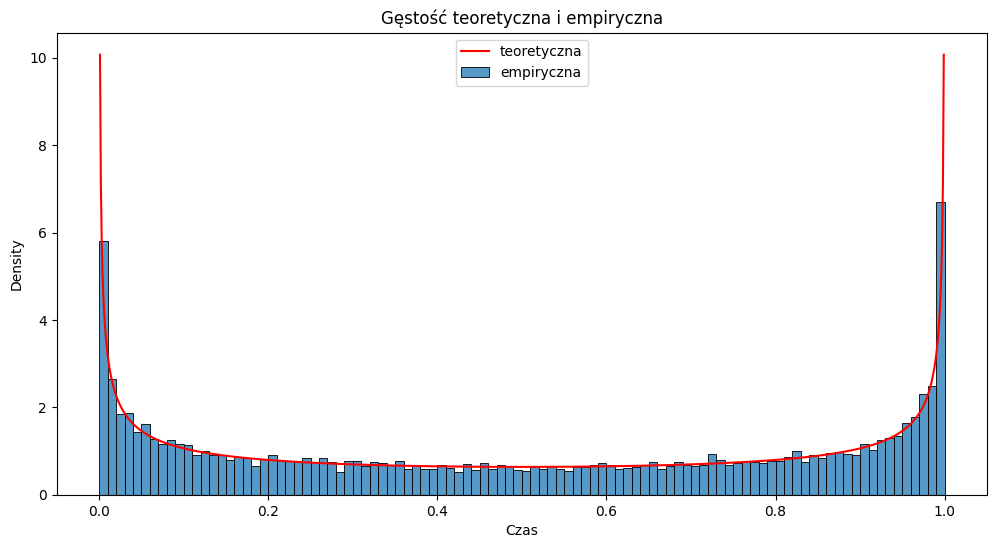

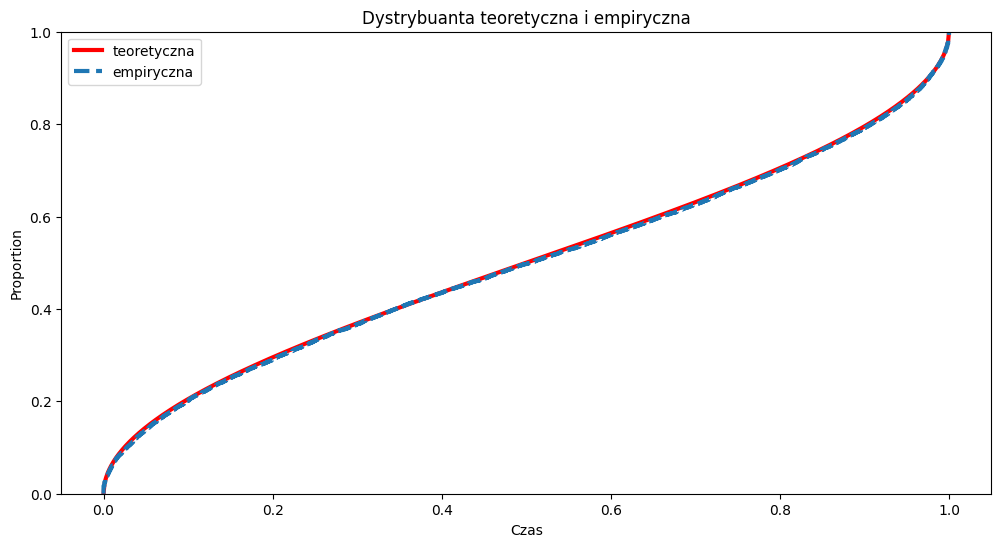

In [103]:
T_positive = []

for _ in range(MC):
    W = wiener_process(T, N)
    T_positive.append(wiener_positive(W, time))


plt.figure(figsize=(12, 6))
plt.plot(time[1:-1], arc_sin_pdf(time[1:-1]),label='teoretyczna',color = 'red')
sns.histplot(T_positive, stat="density", label="empiryczna", bins=100)
plt.xlabel('Czas')
plt.title('Gęstość teoretyczna i empiryczna')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time, arc_sin_cdf(time), linewidth=3, label="teoretyczna", color = 'red')
sns.ecdfplot(T_positive, label='empiryczna',linewidth=3, linestyle='--')
plt.xlabel('Czas')
plt.title('Dystrybuanta teoretyczna i empiryczna')
plt.legend()
plt.show()


## 2. Drugie prawo arcusa sinusa

$$
L = \sup{ \{ t \in [0, 1][W_t = 0] \} } \sim \mathrm{Arcsine}
$$

Inaczej mówiąc, ostatni moment uderzenia procesu Wienera na odcinku [0,1] w oś OX ma rozkład arcusa sinusa.

Na początku zaimplementowano funkcję `last_hit(W,t)` pozwalającą obliczyć wartość L. Generowany proces Wienera nie jest ciągły, ponieważ jest dyskretyzowany przez czas. Z tego względu nie sprawdzano dla jakiego $t$ $W(t)=0$, ponieważ takie podejście doprowadziłoby nas do błędnych wyników. Zamiast tego sprawdzono, dla jakiego $t$, $W(t)$ i $W(t-\Delta t)$ mają różne znaki. Wtedy korzystając z twierdzenia Darboux jesteśmy pewni, że $ \exists \,x \in [t-\Delta t,t]:\, W(x)=0$. W poniższej symulacji założono, że byłby to moment: $\frac{(t-\Delta t) + t}{2} = t - \frac{\Delta t}{2}$.

In [97]:
def last_hit(W, t):
    dt = t[1] - t[0]
    l = 0
    ps = 1 if W[0] >= 0 else -1

    for i, w in enumerate(W):
        cs = 1 if w >= 0 else -1
        if cs != ps:
            l = i * dt
            ps = cs
    
    return l - dt / 2


Następnie przeprowadzono symulacje i porównano dystrybuanty i gęstości.

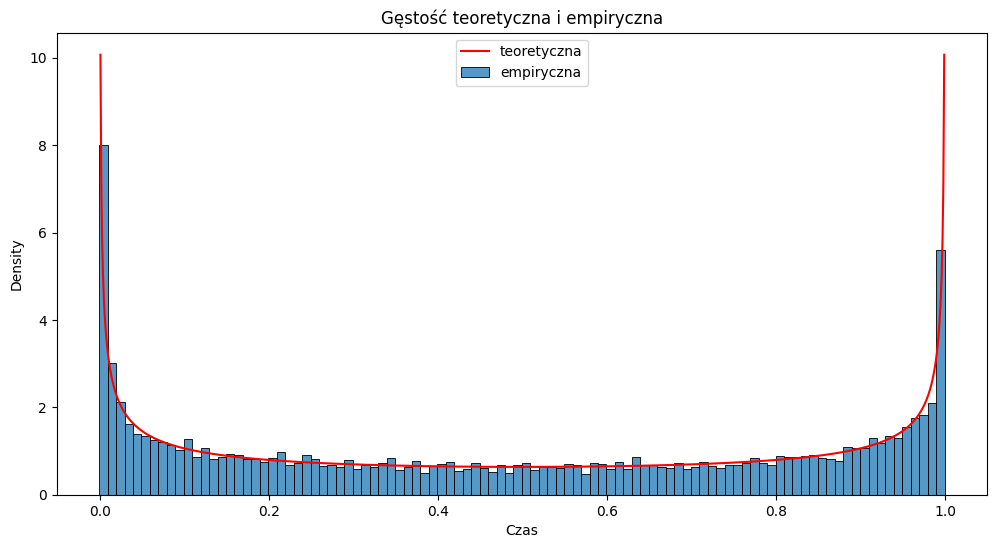

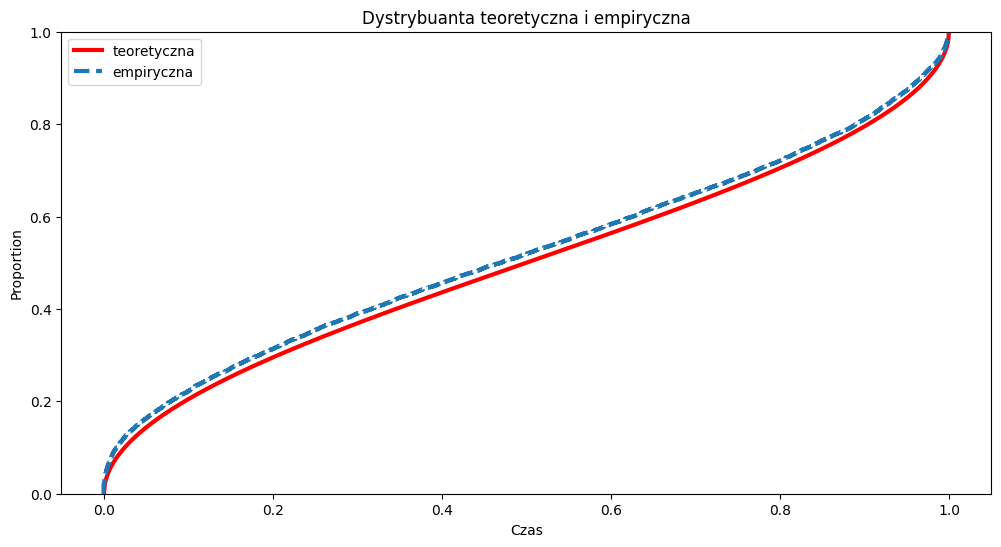

In [104]:
L_values = []
for _ in range(MC):
    W = wiener_process(T, N)
    L_values.append(last_hit(W, time))


plt.figure(figsize=(12, 6))
plt.plot(time[1:-1], arc_sin_pdf(time[1:-1]),label='teoretyczna',color = 'red')
sns.histplot(L_values, stat="density", label="empiryczna", bins=100)
plt.xlabel('Czas')
plt.title('Gęstość teoretyczna i empiryczna')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(time, arc_sin_cdf(time), linewidth=3, label="teoretyczna", color = 'red')
sns.ecdfplot(L_values, label='empiryczna', linewidth=3, linestyle='--')
plt.xlabel('Czas')
plt.title('Dystrybuanta teoretyczna i empiryczna')
plt.legend()
plt.show()

## 3. Trzecie prawo arcusa sinusa
Niech $M$ będzie liczbą spełniającą:
$$
W_M = \sup{ \{ W_t | t \in [0, 1] \} } \sim \mathrm{Arcsine}.
$$
Wtedy $M \sim  \mathrm{Arcsine}$. Oznacza to, że moment osiągnięcia maksymalnej wartości przez proces Wienera na odcinku [0,1] ma rozkład arcusa sinusa.

Pierwszym krokiem było zaimplementowanie funkcji `time_of_max(W)`, która obliczy wartość M.

In [99]:
def time_of_max(W):
    max_arg = np.argmax(W)
    return time[max_arg]

Na koniec przeprowadzono symulację w celu porównania dystrybuant i gęstości empirycznych z teoretycznymi. 

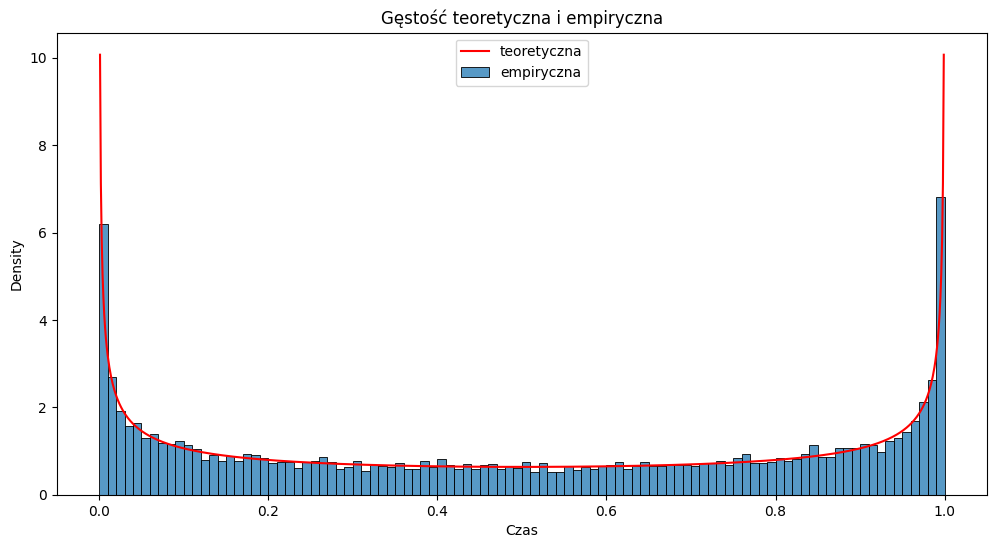

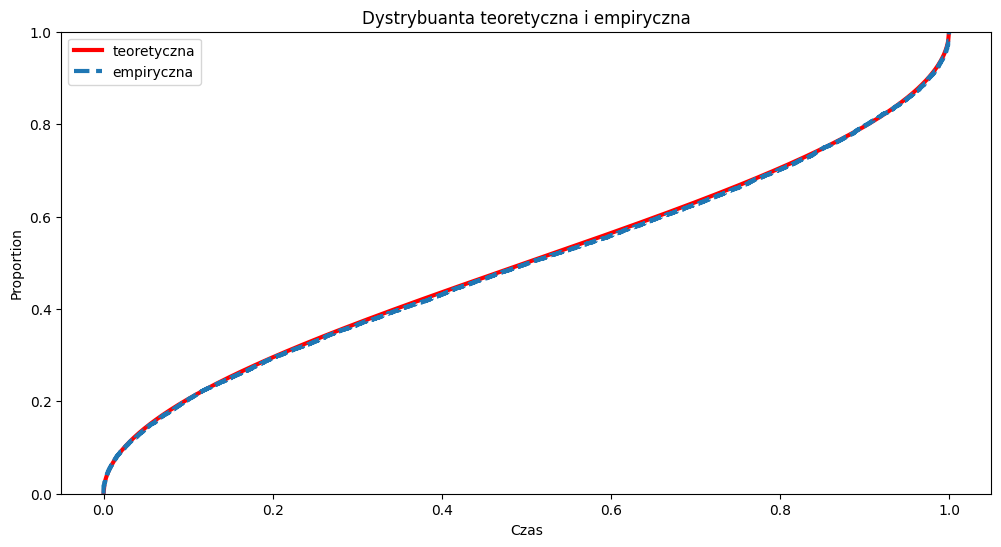

In [105]:
M_values = []
for _ in range(MC):
    W = wiener_process(T, N)
    M_values.append(time_of_max(W))


plt.figure(figsize=(12, 6))
plt.plot(time[1:-1], arc_sin_pdf(time[1:-1]),label='teoretyczna',color = 'red')
sns.histplot(M_values, stat="density", label="empiryczna", bins=100)
plt.xlabel('Czas')
plt.title('Gęstość teoretyczna i empiryczna')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(time, arc_sin_cdf(time), linewidth=3, label="teoretyczna",color = 'red')
sns.ecdfplot(M_values, label='empiryczna', linewidth=3, linestyle='--')
plt.xlabel('Czas')
plt.title('Dystrybuanta teoretyczna i empiryczna')
plt.legend()
plt.show()

## 4. Wnioski
Analizując wyżej przedstawione wykresy, stwierdzono, że przeprowadzone symulacje są efektywne w odwzorowywaniu teoretycznych zależności dla procesu Winera i rozkładu Arcsine. Odnosząc się do pierwszego, drugiego i trzeciego prawa arcsinusa, możemy potwierdzić, że symulacje są zgodne z teoretycznymi założeniami, co potwierdza ich wiarygodność.
Potwierdzenie tych praw dla przeprowadzonych symulacji jest kluczowe, ponieważ świadczy o poprawności oraz adekwatności zastosowanych metod symulacyjnych do badania tych procesów i rozkładów.

